## FC for Widespread Pain Subjects
#### Input: *stc.mat
####  Output: con, visualization

In [1]:
import os
from pathlib import Path
import sys
import mne 
import numpy as np
from mne.datasets import fetch_fsaverage
from tabulate import tabulate
fs_dir = fetch_fsaverage(verbose=True)
subject = "fsaverage"
subjects_dir = os.path.dirname(fs_dir)
sys.path.append("/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/")
from eeg_toolkit import preprocess, utils
import eeg_toolkit.functional_connectivity as fc

0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage
0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage


### Paths

In [2]:
# sl_method = input("Source Localization Method (1- MNE or 2- dSPM): ")
# sl_method = 'MNE' if sl_method == '1' else 'dSPM'
sl_method = 'MNE'
# sl_method = 'dSPM'

In [3]:
# Settings
times_tup, time_win_path = preprocess.get_time_window(5)

# data paths
data_dir = Path("../../Data")
processed_data_path = data_dir / "Processed Data"
stc_path = data_dir / f"Source Time Courses ({sl_method})"
EO_resting_data_path = stc_path / "Eyes Open"
EC_resting_data_path = stc_path / "Eyes Closed"
zscored_epochs_data_path = stc_path / "zscored_Epochs" / time_win_path

# save paths
subset = "Widespread_Pain"
fc_path = data_dir / f"Functional Connectivity ({sl_method})"
fc_subset_path = fc_path / subset
save_path = fc_subset_path

os.makedirs(save_path, exist_ok=True)

[-2.5,0.0,2.5]


### Get subset of subjects with and without widespread pain

### Manually enter age/sex matched subjects

In [4]:
# All CP and HC subs
sub_ids_CP = [  
    '018',  
    '020',  
    '021',  
    '027',  
    '031',  
    '032',  
    '033',  
    '035',  
    '036',  
    '037',  
    '038',  
    '040',  
    '043',  
    '044',  
    '048',  
    '049',  
    '050',  
    '057',  
    '059',
]

sub_ids_HC = [
    'C10',  
    'C11',  
    'C12',  
    'C13',  
    'C14',  
    'C15',  
    'C16',  
    'C17',  
    'C18',  
    'C19',  
    'C2.',  
    'C24',  
    'C25',  
    'C26',  
    'C27',  
    'C3.',  
    'C6.',  
    'C7.',  
    'C9.'  
]  
sub_ids = sub_ids_CP + sub_ids_HC

# TODO: temporary-- These subjects have no keypresses and thus no resting timestamps, but they do have epoched data
NO_KEYPRESS = ['045', 'C1.', 'C5.', 'C8.', 'C20', 'C21', 'C22']
sub_ids = [sub for sub in sub_ids if sub not in NO_KEYPRESS]

# CP Subs with widespread pain
sub_ids_CP_WSP = [
    '018',
    '022',
    '024',
    '031',
    '032',
    '034',
    '036',
    '039',
    '040',
    '045',
    '046',
    '052',
]

# CP Subs with localized pain
sub_ids_CP_LP = [  
    '020',  
    '021',  
    '023',  
    '029',  
    '031',  
    '037',  
    '041',  
    '042',  
    '048',  
    '049',  
    '050',  
    '056'  
]  

In [5]:
# # viable subjects
# sub_ids = utils.import_subs(data_dir, "sub_ids.txt")
# sub_ids = sorted(sub_ids[7:])  # select only 64ch subs and turn into set

# Exclude HEALTHY subjects with widespread pain
widespread_pain_HC = ['C1.','C23']
sub_ids_HC = [sub for sub in sub_ids_HC if sub not in widespread_pain_HC]

# Exclude subjects with low trial count
# TODO: figure out how to skip
# C5 i think missing resting but has X trials
# sub_ids_CP_WSP.remove('055') 
# 036 has 6; 037 has 6, 044 has 5, 056 has 5, 058 has 4 (Localized pain)
# sub_ids_CP_LP.remove(['036', '037', '044', '056', '058'])

In [6]:
print(f"Chronics (all): {len(sub_ids_CP)}")
print([el for el in sub_ids_CP])
print(f"Chronics with widespread pain: {len(sub_ids_CP_WSP)}")
print([el for el in sub_ids_CP_WSP])
print(f"Chronics with localized pain: {len(sub_ids_CP_LP)}")
print([sub for sub in sub_ids_CP_LP])
print(f"Controls: {len(sub_ids_HC)}")
print([el for el in sub_ids_HC])
print(f"\nTotal (Chronics + Controls): {len(sub_ids)}")


Chronics (all): 19
['018', '020', '021', '027', '031', '032', '033', '035', '036', '037', '038', '040', '043', '044', '048', '049', '050', '057', '059']
Chronics with widespread pain: 11
['018', '022', '024', '031', '032', '034', '036', '039', '040', '046', '052']
Chronics with localized pain: 12
['020', '021', '023', '029', '031', '037', '041', '042', '048', '049', '050', '056']
Controls: 19
['C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C2.', 'C24', 'C25', 'C26', 'C27', 'C3.', 'C6.', 'C7.', 'C9.']

Total (Chronics + Controls): 38


### Settings for conditions/bands/methods

In [7]:
# Settings
sfreq = 400  # Hz
tmin, tmax = 0.0, 1.25  # exclude the baseline period for connectivity estimation

# Use canonical bands or narrower bands
# narrow_bands = False 
narrow_bands = True 

# Choose which connectivity estimates to run. "amplitude", "phase", or "both"
# method_choice = "phase"
method_choice = "both"

# Include intermediate stimulus?
include_LS = False

# Load previously saved group data
# load_group_data_flag = False
load_group_data_flag = True

# Save group data?
save_group_data_flag = False
# save_group_data_flag = True

# Evoked only or include resting too?
include_resting = True
# include_resting = False

### Define ROIs, frequency bands, conditions, and methods for FC

In [8]:
####################################################################
# REGIONS OF INTEREST
roi_names = [  # Left
    "rostralanteriorcingulate-lh",  # Left Rostral ACC
    "caudalanteriorcingulate-lh",  # Left Caudal ACC
    "postcentral-lh",  # Left S1,
    "insula-lh",
    "superiorfrontal-lh",  # Left Insula, Left DL-PFC,
    "medialorbitofrontal-lh",  # Left Medial-OFC
    # Right
    "rostralanteriorcingulate-rh",  # Right Rostral ACC
    "caudalanteriorcingulate-rh",  # Right Caudal ACC
    "postcentral-rh",  # , Right S1
    "insula-rh",
    "superiorfrontal-rh",  # Right Insula, Right DL-PFC
    "medialorbitofrontal-rh",
]  # Right Medial-OFC

# Write out ROI names as acronyms
roi_acronyms = ["rACC-lh", "dACC-lh", "S1-lh", "insula-lh", "dlPFC-lh", "mOFC-lh",
                "rACC-rh", "dACC-rh", "S1-rh", "insula-rh", "dlPFC-rh", "mOFC-rh"]


####################################################################
# BANDS OF INTEREST
if not narrow_bands:
    Freq_Bands = {
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        # "alpha": [8.0, 13.0],
        # "beta": [13.0, 30.0],
        # "low-gamma": [30.0, 58.5],
        # # "notch": [58.5, 61.5],
        # "high-gamma": [61.5, 100.0],
    }
else:
    Freq_Bands = { # Narrower bands and overlaps
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        "low-alpha": [8.0, 10.0],
        "high-alpha": [10.0, 13.0],
        # "low-beta": [13.0, 22.0],
        # "high-beta": [22.0, 30.0],
        "low-gamma-i": [30.0, 45.0],
        "low-gamma-ii": [45.0, 60.0],
        # # "notch": [58.5, 61.5],
        "high-gamma-i": [60.0, 80.0],
        "high-gamma-ii": [80.0, 100.0],
    }
band_names = [band for band in Freq_Bands]

####################################################################
# CONNECTIVITY METHODS
if method_choice == "phase":
    con_methods = ["wpli2_debiased",
                ]
elif method_choice == "amplitude":
    con_methods = [
        # "aec_pairwise",
        "aec_symmetric",
        ]
elif method_choice == "both":
    con_methods = [
    "wpli2_debiased",
    # "aec_pairwise",
    "aec_symmetric", # keep only symmetric for now
    ]
    
####################################################################
# CONDITIONS
conditions = (
    [
        "Hand 32 mN",
        "Hand 128 mN",
        "Hand 256 mN",
        "Back 32 mN",
        "Back 128 mN",
        "Back 256 mN",
        "Eyes Open",
        "Eyes Closed",
    ]
    if include_LS
    else [
        # "Hand 32 mN",
        # 'Hand LS',
        "Hand 256 mN",
        # "Back 32 mN",
        # 'Back LS',
        # "Back 256 mN",
        "Eyes Open",
        # "Eyes Closed",
    ]
)

# Choose to exclude resting state data
conditions = conditions if include_resting else [
    c for c in conditions if "Eyes" not in c
]

####################################################################
# CONDITION DICTIONARY
condition_dict = {
        "Hand 32 mN": 0,
        'Hand LS': 1,
        "Hand 256 mN": 2,
        "Back 32 mN": 3,
        'Back LS': 4,
        "Back 256 mN": 5,
        "Eyes Open": 6,
        "Eyes Closed": 7,
}

####################################################################
# GROUP NAMES
groups=['Chronic Pain with Widespread Pain','Chronic Pain', 'Healthy Control']

### Compute functional connectivity for each subject in each group

In [ ]:
# Healthy Control group
if not load_group_data_flag:
    sub_con_HC = {}
    for sub_id in sub_ids_HC:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Healthy Control",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            Freq_Bands,
            tmin,
            tmax,
            sfreq,
            include_LS=include_LS,
        )
        sub_con_HC[sub_id] = sub_avg_cons
    utils.clear_display()

In [ ]:
# Chronics (all) group
if not load_group_data_flag:
    sub_con_CP = {}
    for sub_id in sub_ids_CP:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Chronic Pain",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            Freq_Bands,
            tmin,
            tmax,
            sfreq,
            include_LS=include_LS,
        )
        sub_con_CP[sub_id] = sub_avg_cons
    utils.clear_display()

In [ ]:
# CLBP with WSP
if not load_group_data_flag:
    sub_con_CP_WSP = {}
    for sub_id in sub_ids_CP_WSP:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Chronic Pain w/ WSP",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            Freq_Bands,
            tmin,
            tmax,
            sfreq,
            include_LS=include_LS,
        )
        sub_con_CP_WSP[sub_id] = sub_avg_cons
        
    utils.clear_display()

In [ ]:
# CLBP with LP
if not load_group_data_flag:
    sub_con_CP_LP = {}
    for sub_id in sub_ids_CP_LP:
        print(sub_id)
        sub_avg_cons = fc.compute_sub_avg_con(
            sub_id,
            "Chronic Pain w/ Localized Pain",
            processed_data_path,
            zscored_epochs_data_path,
            EO_resting_data_path,
            EC_resting_data_path,
            con_methods,
            conditions,
            condition_dict,
            roi_names,
            Freq_Bands,
            tmin,
            tmax,
            sfreq,
            include_LS=include_LS,
        )
        sub_con_CP_LP[sub_id] = sub_avg_cons
        
    utils.clear_display()

In [13]:
# Checkpoint path
checkpoint_path = save_path / f"Checkpoints: {[el for el in conditions]}"
os.makedirs(checkpoint_path, exist_ok=True)
print(f"Loading checkpoints from {checkpoint_path}")

if not load_group_data_flag:
    # Stack the connectivity of all subjects in each group
    group_con_HC = fc.compute_group_con(sub_con_HC, conditions, con_methods, band_names)
    group_con_CP = fc.compute_group_con(sub_con_CP, conditions, con_methods, band_names)
    group_con_CP_WSP = fc.compute_group_con(sub_con_CP_WSP, conditions, con_methods, band_names)
    group_con_CP_LP = fc.compute_group_con(sub_con_CP_LP, conditions, con_methods, band_names)
else:
    group_con_HC = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_HC.pkl")
    group_con_CP = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_CP.pkl")
    group_con_CP_WSP = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_CP_WSP.pkl")
    group_con_CP_LP = utils.unpickle_data(checkpoint_path, f"group_con_{subset}_CP_LP.pkl")

    sub_con_HC = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_HC.pkl")
    sub_con_CP = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_CP.pkl")
    sub_con_CP_WSP = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_CP_WSP.pkl")
    sub_con_CP_LP = utils.unpickle_data(checkpoint_path, f"sub_con_{subset}_CP_LP.pkl")

Loading checkpoints from ../../Data/Functional Connectivity (MNE)/Widespread_Pain/Checkpoints: ['Hand 256 mN', 'Eyes Open']
Group connectivity completed.
Group connectivity completed.
Group connectivity completed.
Group connectivity completed.


In [14]:
if save_group_data_flag:
    # Save/checkpoint as pickle
    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_HC.pkl", sub_con_HC)
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_HC.pkl", group_con_HC)
    
    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_CP.pkl", sub_con_CP)
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_CP.pkl", group_con_CP)
    
    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_CP_WSP.pkl", sub_con_CP_WSP)
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_CP_WSP.pkl", group_con_CP_WSP)

    utils.pickle_data(checkpoint_path, f"sub_con_{subset}_CP_LP.pkl", sub_con_CP_LP)
    utils.pickle_data(checkpoint_path, f"group_con_{subset}_CP_LP.pkl", group_con_CP_LP)

Saved sub_con_Widespread_Pain_HC.pkl to ../../Data/Functional Connectivity (MNE)/Widespread_Pain/Checkpoints: ['Hand 256 mN', 'Eyes Open'].
Saved group_con_Widespread_Pain_HC.pkl to ../../Data/Functional Connectivity (MNE)/Widespread_Pain/Checkpoints: ['Hand 256 mN', 'Eyes Open'].
Saved sub_con_Widespread_Pain_CP.pkl to ../../Data/Functional Connectivity (MNE)/Widespread_Pain/Checkpoints: ['Hand 256 mN', 'Eyes Open'].
Saved group_con_Widespread_Pain_CP.pkl to ../../Data/Functional Connectivity (MNE)/Widespread_Pain/Checkpoints: ['Hand 256 mN', 'Eyes Open'].
Saved sub_con_Widespread_Pain_CP_WSP.pkl to ../../Data/Functional Connectivity (MNE)/Widespread_Pain/Checkpoints: ['Hand 256 mN', 'Eyes Open'].
Saved group_con_Widespread_Pain_CP_WSP.pkl to ../../Data/Functional Connectivity (MNE)/Widespread_Pain/Checkpoints: ['Hand 256 mN', 'Eyes Open'].
Saved sub_con_Widespread_Pain_CP_LP.pkl to ../../Data/Functional Connectivity (MNE)/Widespread_Pain/Checkpoints: ['Hand 256 mN', 'Eyes Open'].
Sav

### Plot settings

### Plot and compute satistics to assess statistical differences 

In [15]:
# Highlight p-values with red box automatically
highlight_pvals=False

# Make any non-significant squares white
show_only_significant=True

# Set title automatically
set_title=True

# Show values in the matrix quadrants
show_fc_vals=True

# Round negative values to zero 
# (Vinck. et al 2011 has negative values for WPLI 2 Debiased. NO ROUNDING)
round_neg_vals=False

# Plot 3D brain visualization (for AEC only)
plot_brain=False


Hand 256 mN - Chronic Pain vs. Healthy Control - wpli2_debiased - theta
Top 3 Connections in Chronic Pain group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| dACC-rh <-> dACC-lh  |     4     |     0.505     |
| mOFC-rh <-> dlPFC-lh |     3     |     0.479     |
| dlPFC-rh <-> dACC-lh |     3     |     0.384     |
+----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
| mOFC-rh <-> rACC-rh |     3     |     0.44      |
| mOFC-rh <-> mOFC-lh |     2     |     0.38      |
| mOFC-rh <-> rACC-lh |     2     |     0.443     |
+---------------------+-----------+---------------+ 

Num epochs: 209 vs. 212
+-----------------------+---------+----------------+----------------+
|       ROI 

<Figure size 640x480 with 0 Axes>

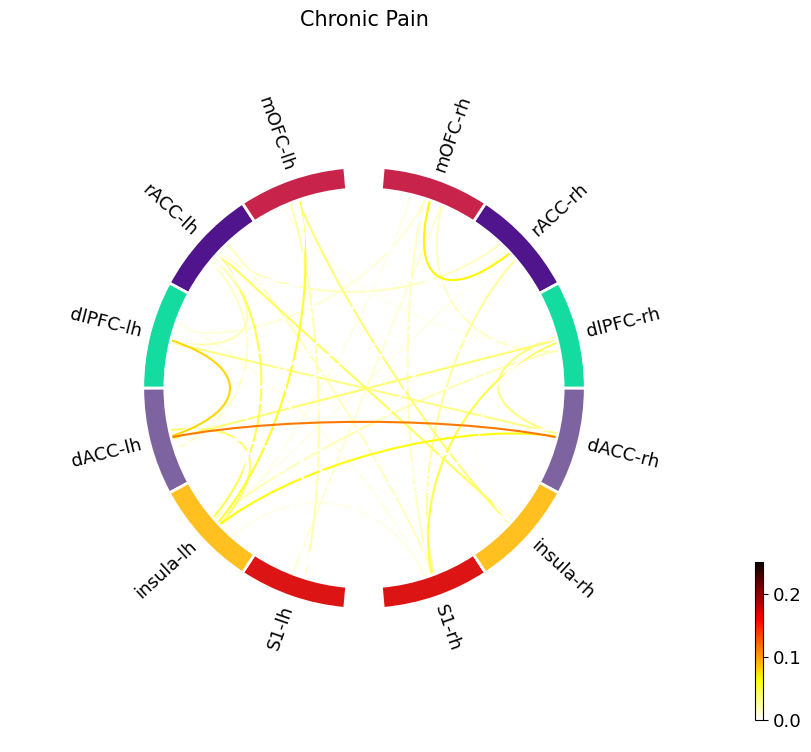

<Figure size 640x480 with 0 Axes>

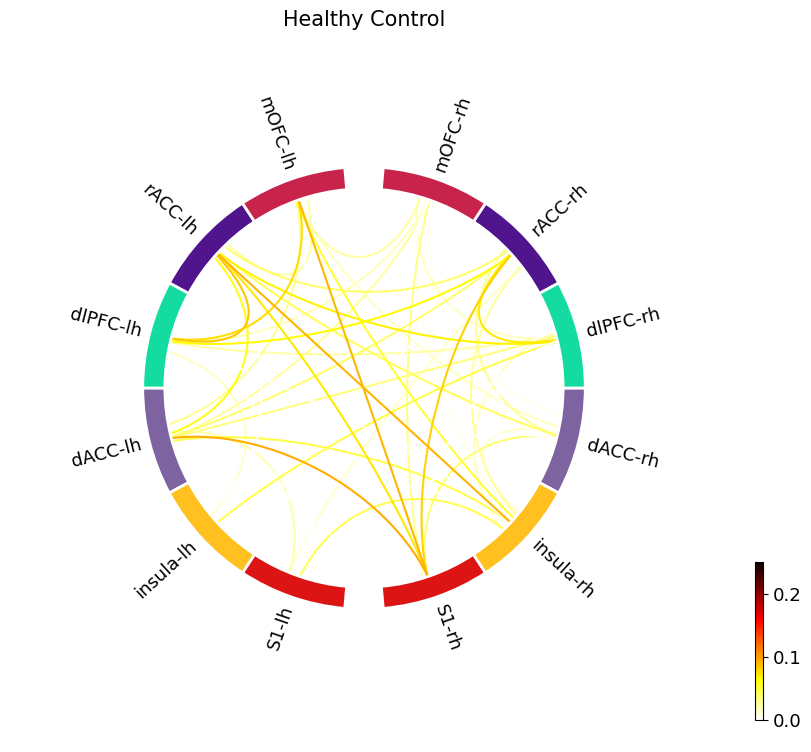

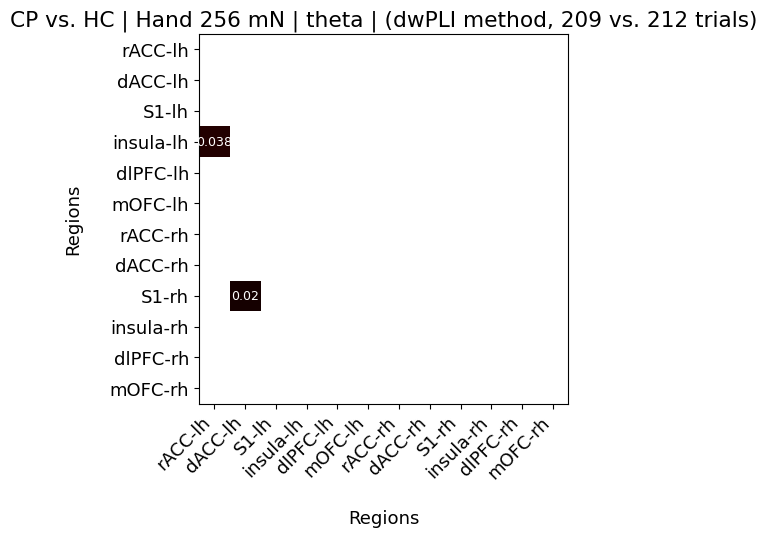

Hand 256 mN - Chronic Pain vs. Healthy Control - wpli2_debiased - low-alpha
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| insula-rh <-> rACC-lh |     4     |     0.65      |
|  mOFC-rh <-> mOFC-lh  |     3     |     0.697     |
|  insula-lh <-> S1-lh  |     3     |     0.578     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| mOFC-lh <-> dlPFC-lh  |     4     |     0.66      |
| insula-rh <-> dACC-rh |     3     |     0.352     |
|  insula-rh <-> S1-rh  |     2     |     0.61      |
+-----------------------+-----------+---------------+ 

Num epochs: 209 vs. 212
+--------------------+---------+----------------+--------

<Figure size 640x480 with 0 Axes>

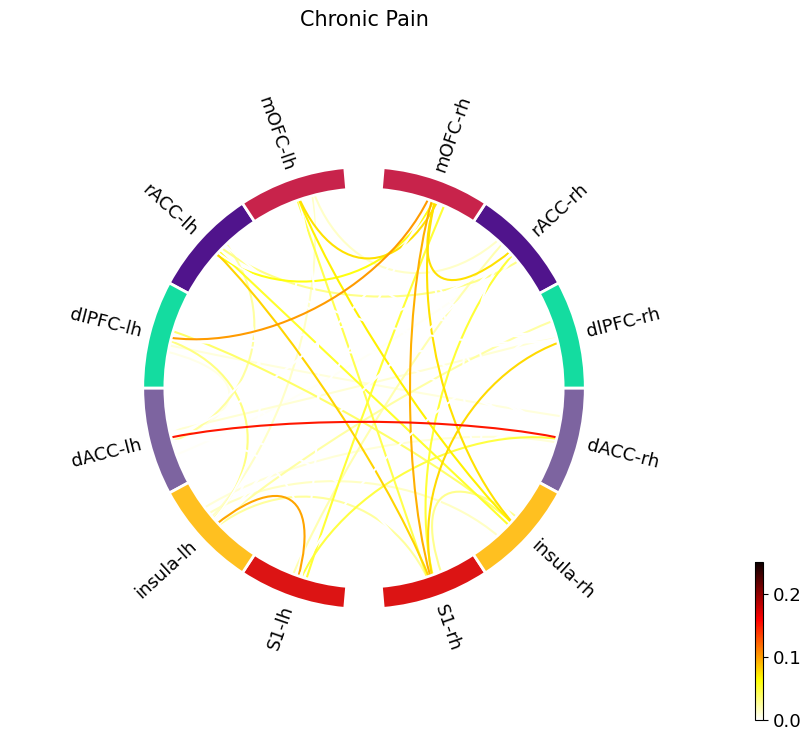

<Figure size 640x480 with 0 Axes>

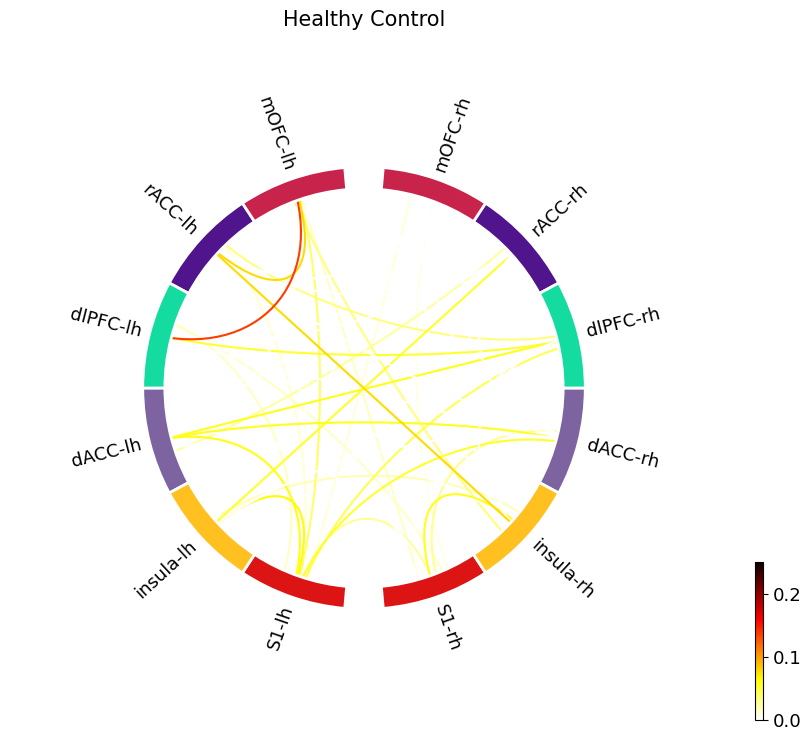

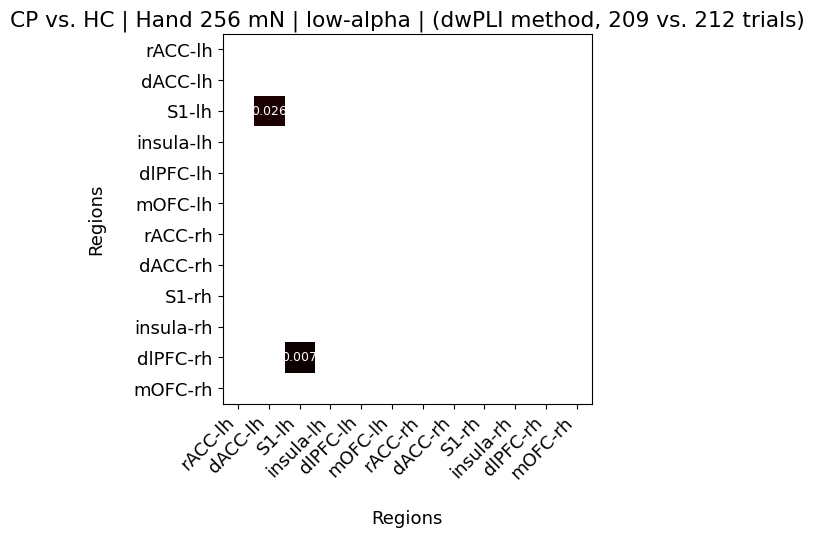

Hand 256 mN - Chronic Pain vs. Healthy Control - wpli2_debiased - high-alpha
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  dlPFC-rh <-> S1-rh   |     4     |     0.513     |
| rACC-rh <-> insula-lh |     3     |     0.44      |
|  mOFC-rh <-> mOFC-lh  |     2     |     0.363     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control group
+-------------------------+-----------+---------------+
|       Connection        | Frequency | Mean Strength |
+-------------------------+-----------+---------------+
| insula-rh <-> insula-lh |     3     |     0.312     |
|   mOFC-rh <-> rACC-rh   |     3     |     0.436     |
|   dACC-rh <-> rACC-lh   |     3     |     0.55      |
+-------------------------+-----------+---------------+ 

Num epochs: 209 vs. 212
+------------------------+---------+------

<Figure size 640x480 with 0 Axes>

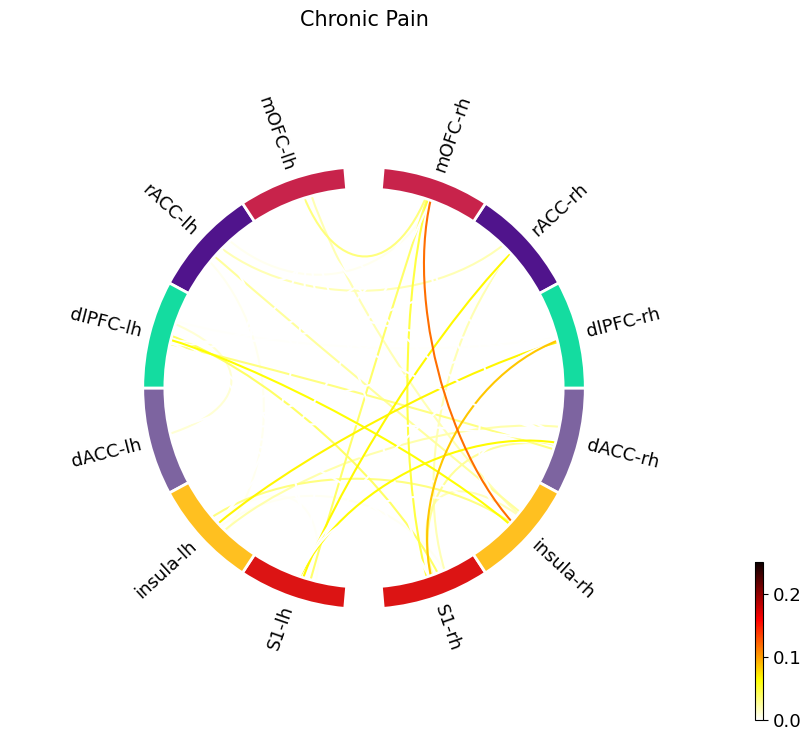

<Figure size 640x480 with 0 Axes>

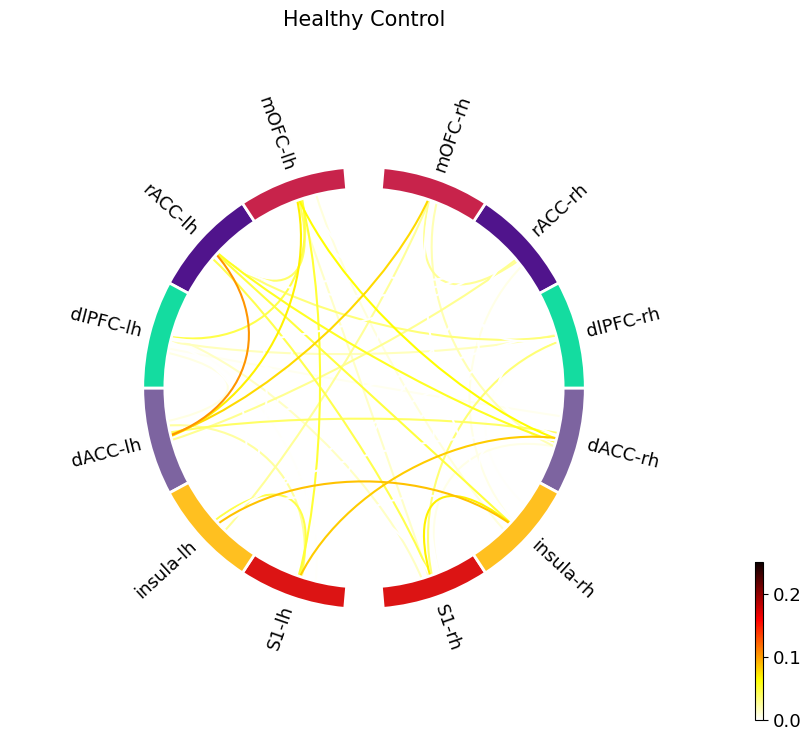

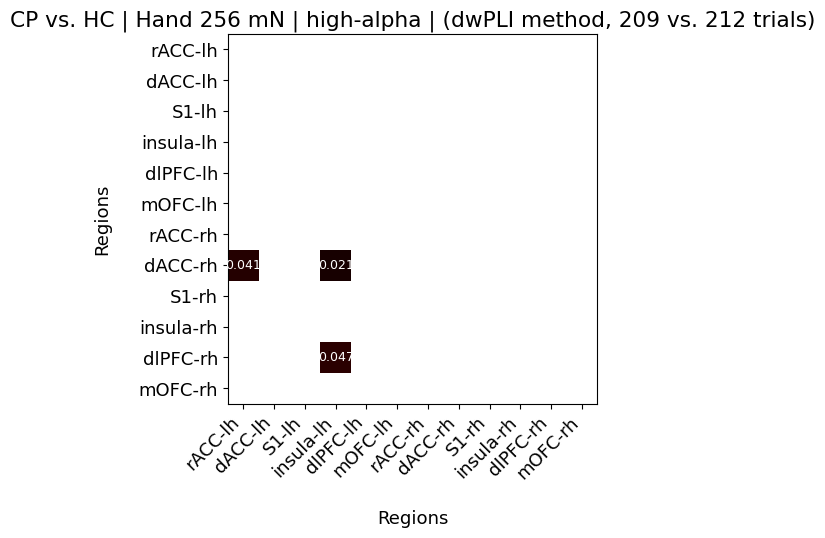

Hand 256 mN - Chronic Pain vs. Healthy Control - wpli2_debiased - low-gamma-i
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| insula-rh <-> mOFC-lh |     5     |     0.225     |
|  dACC-rh <-> rACC-lh  |     4     |     0.332     |
| insula-rh <-> rACC-lh |     3     |     0.256     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
| mOFC-rh <-> rACC-rh |     3     |     0.227     |
| dACC-lh <-> rACC-lh |     3     |     0.232     |
|  S1-rh <-> mOFC-lh  |     2     |     0.318     |
+---------------------+-----------+---------------+ 

Num epochs: 209 vs. 212
+------------------------+---------+----------------+----------------

<Figure size 640x480 with 0 Axes>

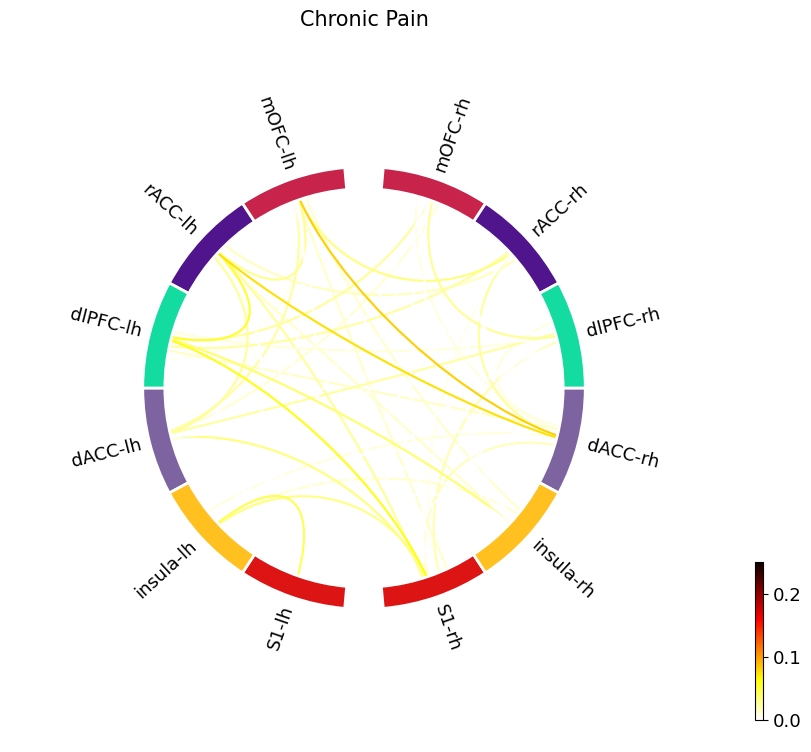

<Figure size 640x480 with 0 Axes>

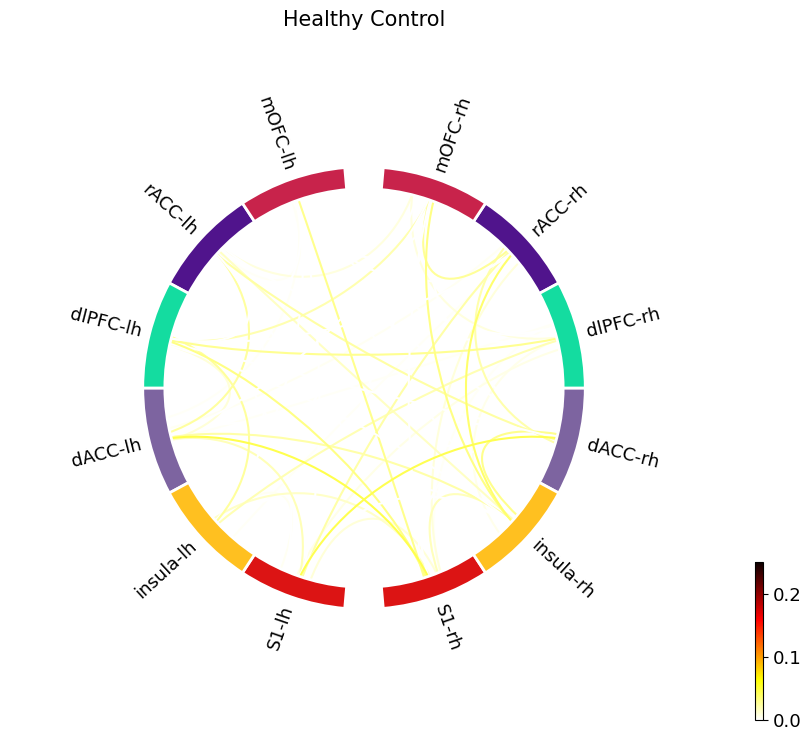

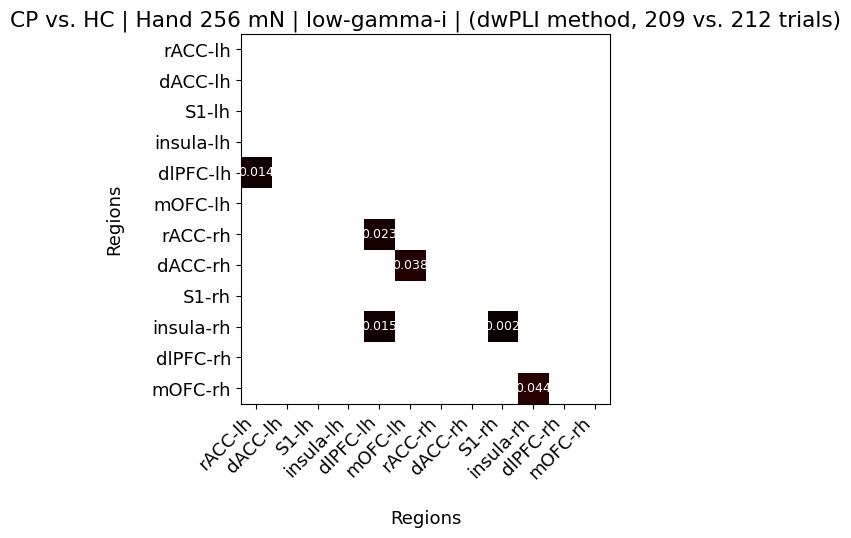

Hand 256 mN - Chronic Pain vs. Healthy Control - wpli2_debiased - low-gamma-ii
Top 3 Connections in Chronic Pain group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
|  mOFC-rh <-> S1-lh  |     4     |     0.326     |
| dACC-lh <-> rACC-lh |     3     |     0.218     |
| mOFC-rh <-> dACC-lh |     3     |     0.259     |
+---------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
| insula-rh <-> S1-lh |     4     |     0.171     |
|  S1-rh <-> dACC-rh  |     3     |     0.225     |
| mOFC-lh <-> dACC-lh |     3     |     0.278     |
+---------------------+-----------+---------------+ 

Num epochs: 209 vs. 212
+-------------------+---------+----------------+----------------+
|     ROI Pair  

<Figure size 640x480 with 0 Axes>

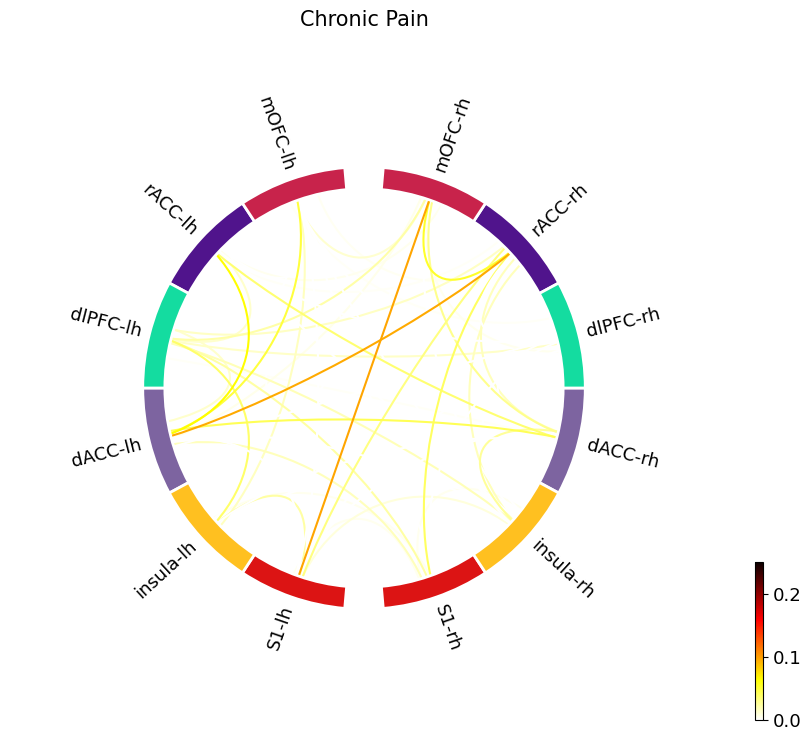

<Figure size 640x480 with 0 Axes>

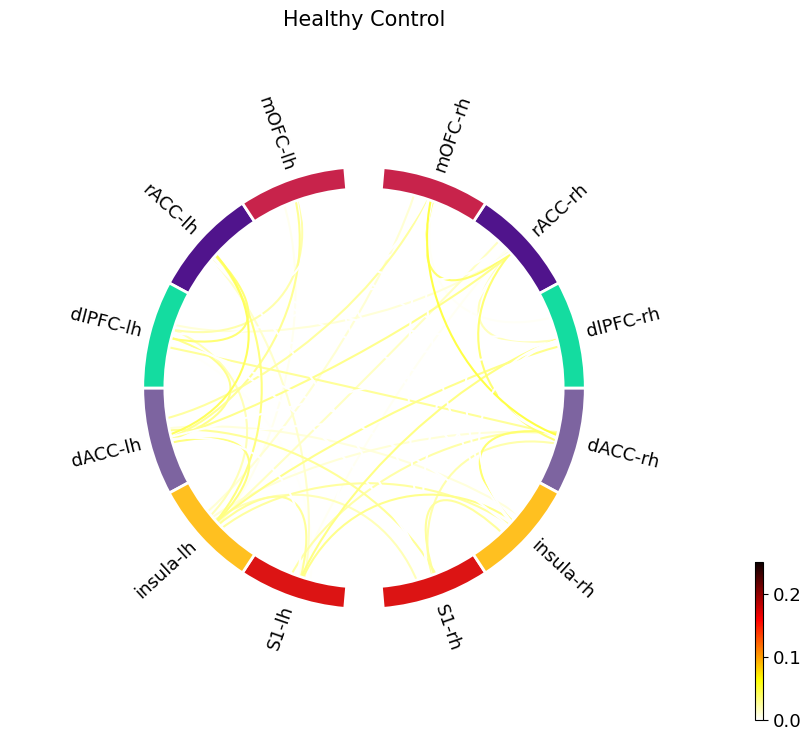

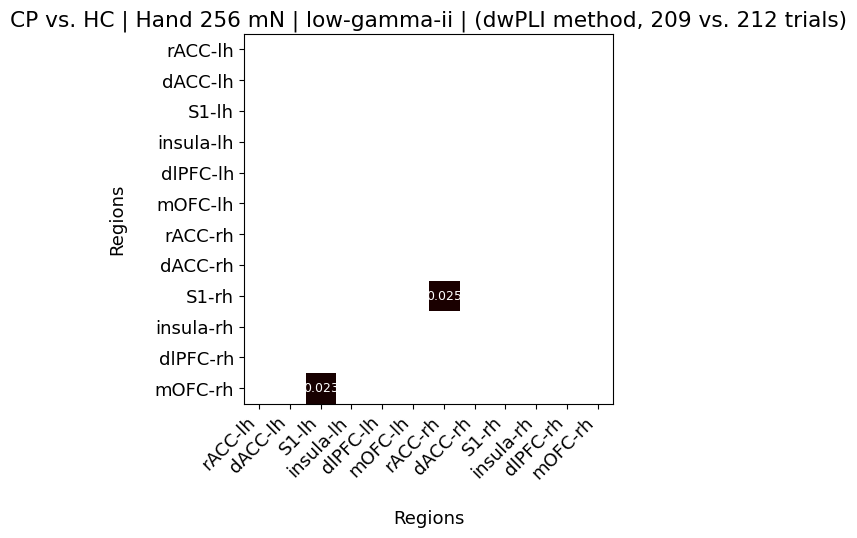

Hand 256 mN - Chronic Pain vs. Healthy Control - wpli2_debiased - high-gamma-i
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  mOFC-lh <-> rACC-lh  |     4     |     0.196     |
|  dACC-rh <-> rACC-rh  |     4     |     0.22      |
| insula-rh <-> rACC-rh |     4     |     0.246     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| insula-rh <-> dACC-lh |     3     |     0.179     |
|  insula-rh <-> S1-rh  |     3     |     0.181     |
| dACC-rh <-> insula-lh |     3     |     0.182     |
+-----------------------+-----------+---------------+ 

Num epochs: 209 vs. 212
+-------------------------+---------+----------------+

<Figure size 640x480 with 0 Axes>

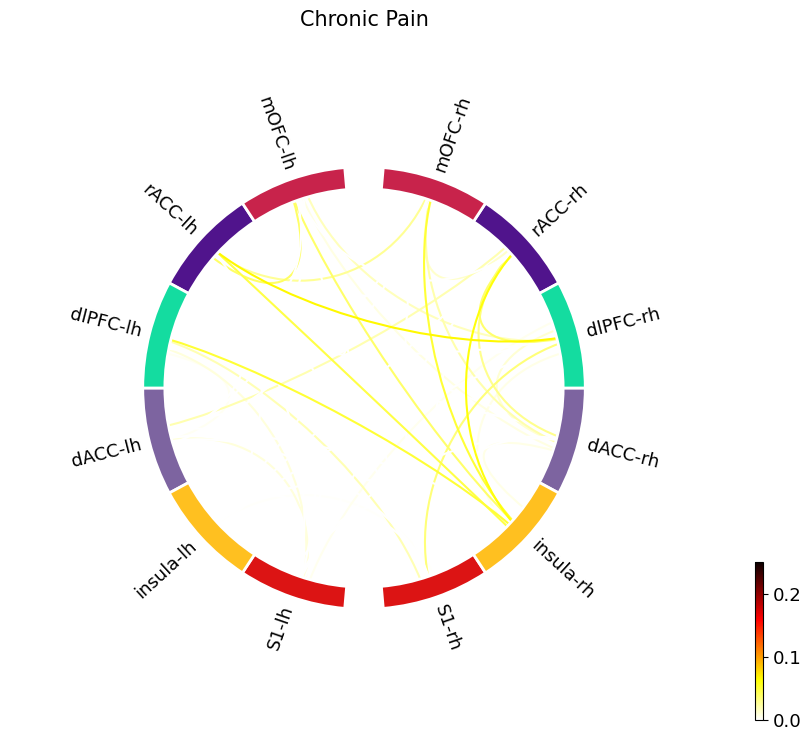

<Figure size 640x480 with 0 Axes>

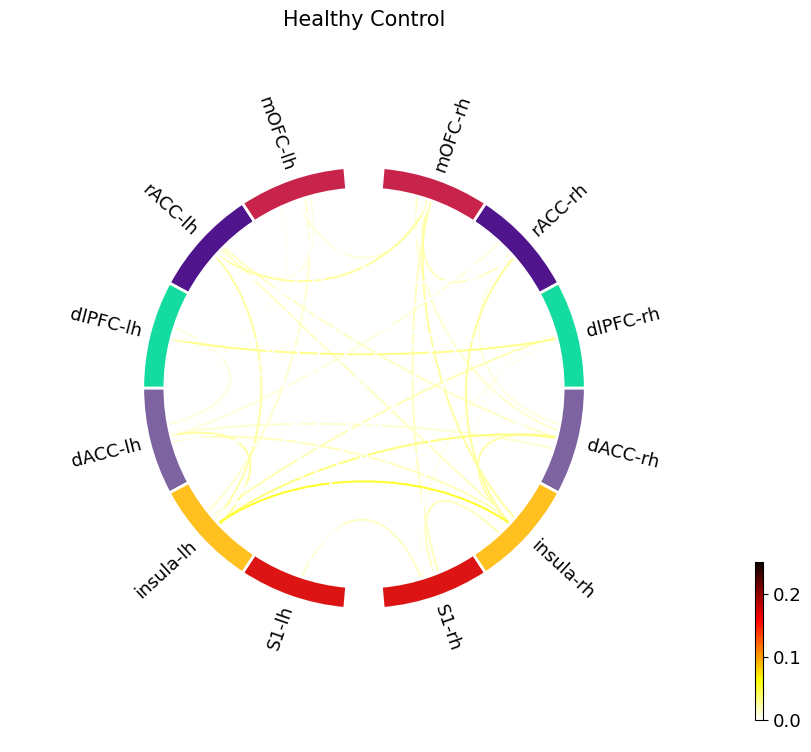

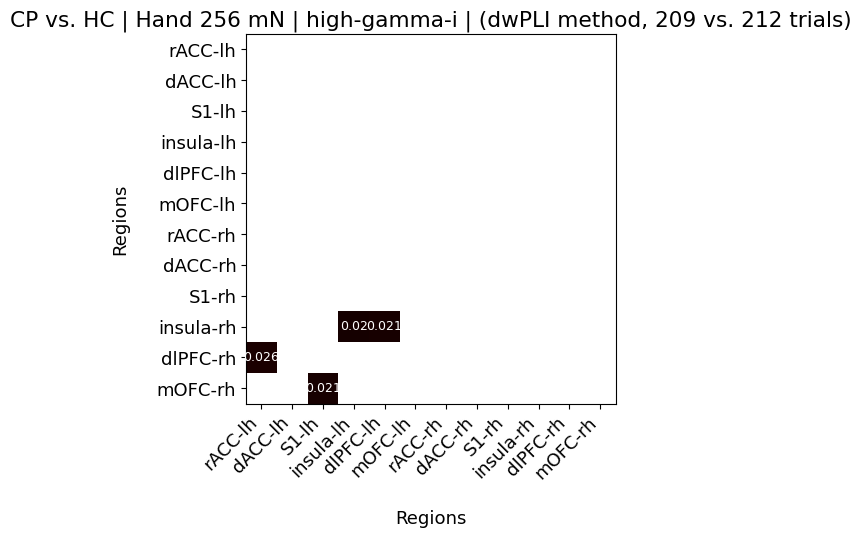

Hand 256 mN - Chronic Pain vs. Healthy Control - wpli2_debiased - high-gamma-ii
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|    S1-rh <-> S1-lh    |     4     |     0.225     |
| insula-rh <-> mOFC-lh |     4     |     0.248     |
|   rACC-rh <-> S1-lh   |     3     |     0.269     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control group
+------------------------+-----------+---------------+
|       Connection       | Frequency | Mean Strength |
+------------------------+-----------+---------------+
| dlPFC-lh <-> insula-lh |     3     |     0.241     |
|  dlPFC-rh <-> mOFC-lh  |     3     |     0.195     |
|  S1-rh <-> insula-lh   |     3     |     0.298     |
+------------------------+-----------+---------------+ 

Num epochs: 209 vs. 212
+---------------------+---------+-------------

<Figure size 640x480 with 0 Axes>

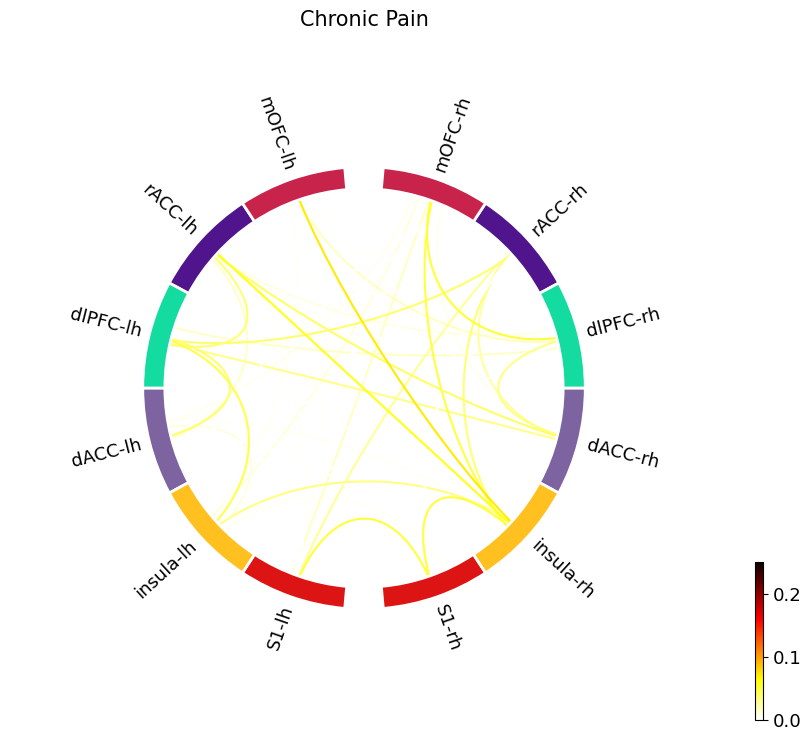

<Figure size 640x480 with 0 Axes>

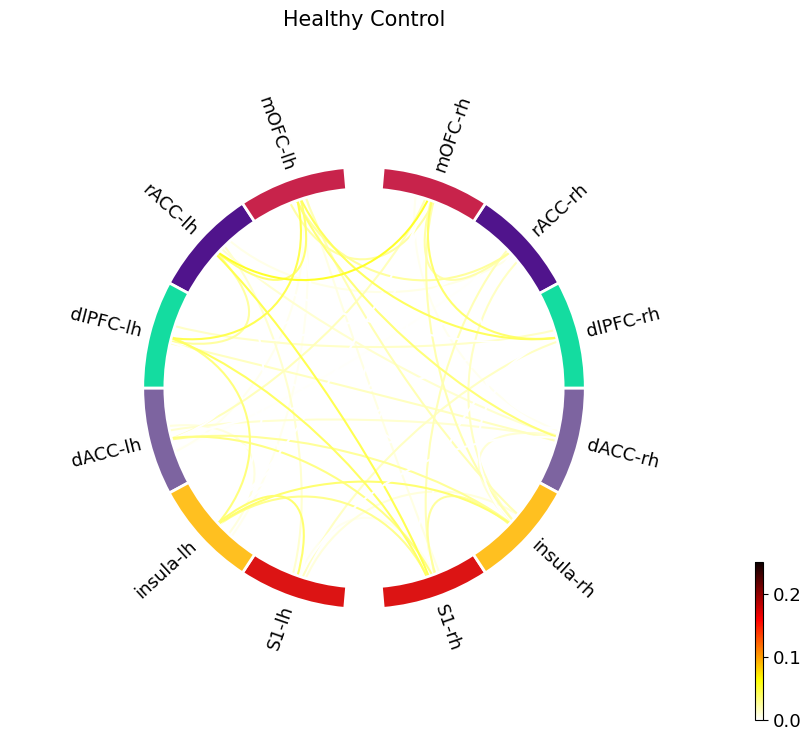

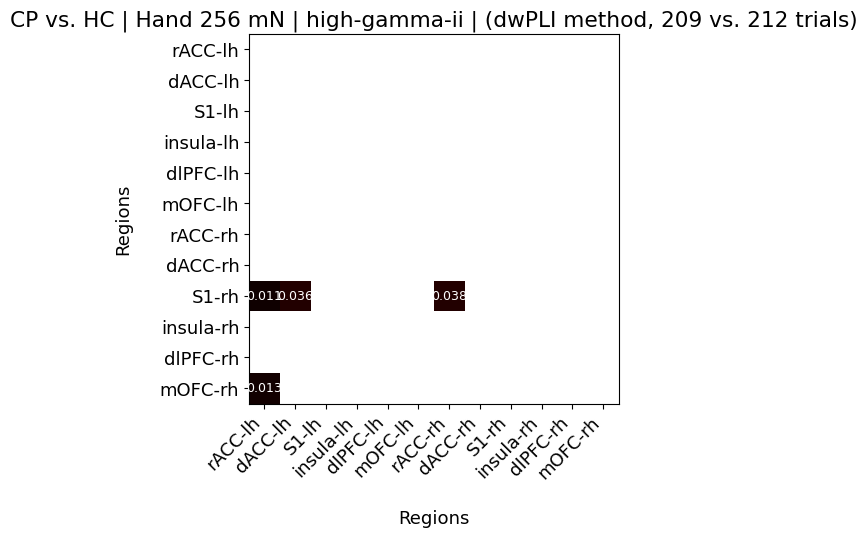

Eyes Open - Chronic Pain vs. Healthy Control - aec_symmetric - theta
Top 3 Connections in Chronic Pain group
+------------------------+-----------+---------------+
|       Connection       | Frequency | Mean Strength |
+------------------------+-----------+---------------+
| dlPFC-rh <-> insula-rh |     6     |     0.742     |
| dlPFC-rh <-> insula-lh |     3     |     0.748     |
|  mOFC-rh <-> mOFC-lh   |     3     |     0.812     |
+------------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh  |     5     |     0.779     |
| dlPFC-rh <-> dACC-rh  |     3     |     0.881     |
| insula-rh <-> dACC-lh |     3     |     0.784     |
+-----------------------+-----------+---------------+ 

Num epochs: 228 vs. 228
+------------------------+---------+----------------+----

<Figure size 640x480 with 0 Axes>

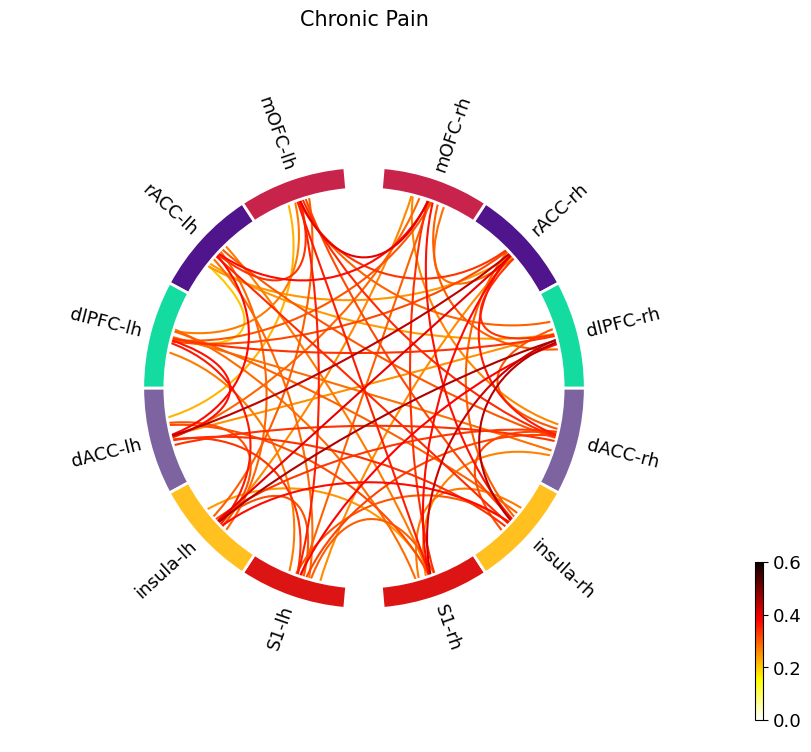

<Figure size 640x480 with 0 Axes>

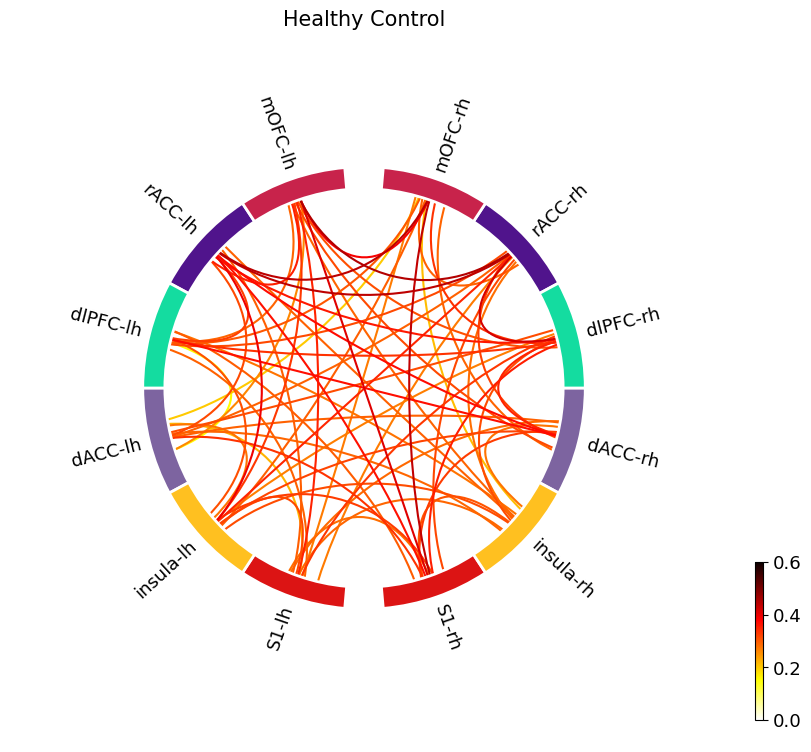

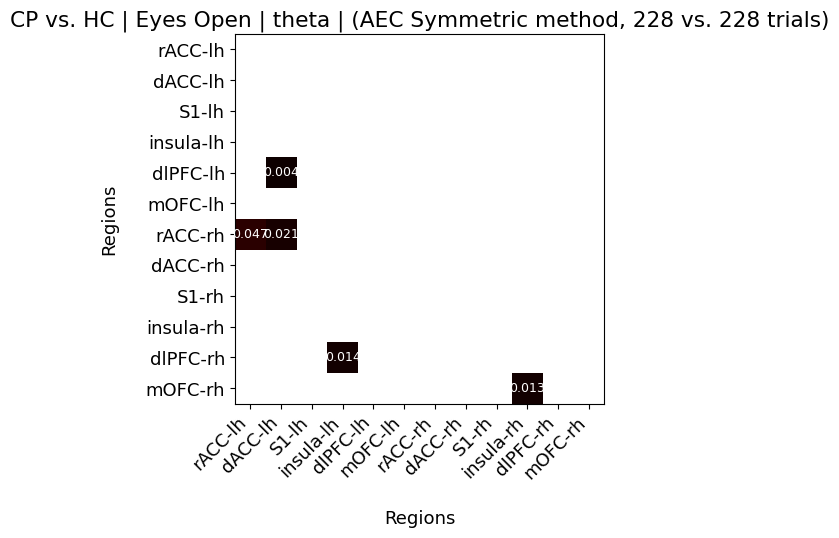

Eyes Open - Chronic Pain vs. Healthy Control - aec_symmetric - low-alpha
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  mOFC-rh <-> rACC-lh  |     4     |     0.888     |
| mOFC-rh <-> dlPFC-rh  |     3     |     0.868     |
| insula-rh <-> dACC-rh |     3     |     0.932     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control group
+------------------------+-----------+---------------+
|       Connection       | Frequency | Mean Strength |
+------------------------+-----------+---------------+
|  dlPFC-rh <-> dACC-rh  |     4     |     0.871     |
| dlPFC-rh <-> insula-rh |     3     |     0.948     |
|  mOFC-lh <-> rACC-lh   |     2     |     0.963     |
+------------------------+-----------+---------------+ 

Num epochs: 228 vs. 228
+----------+---------+----------------+--------------

<Figure size 640x480 with 0 Axes>

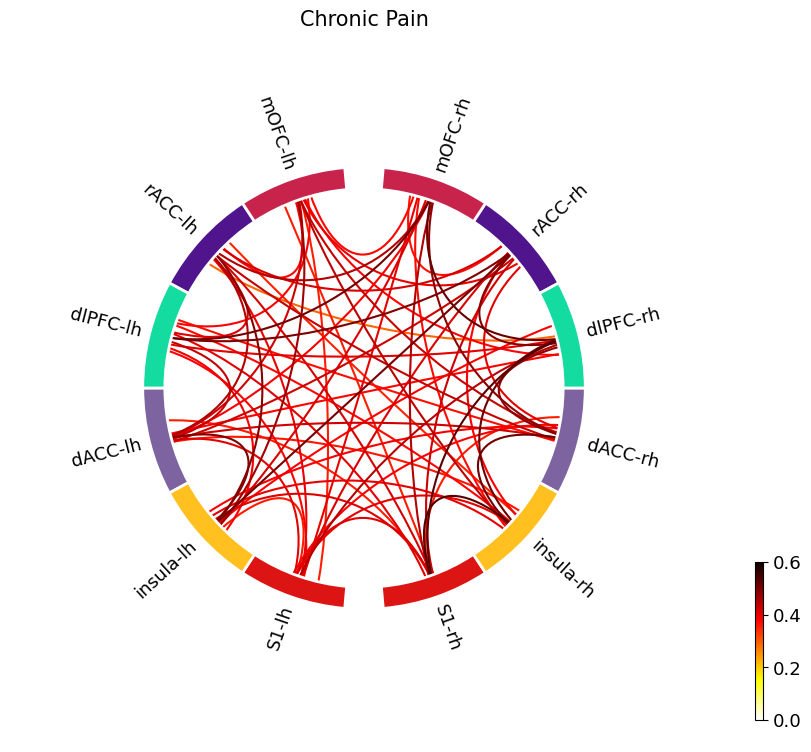

<Figure size 640x480 with 0 Axes>

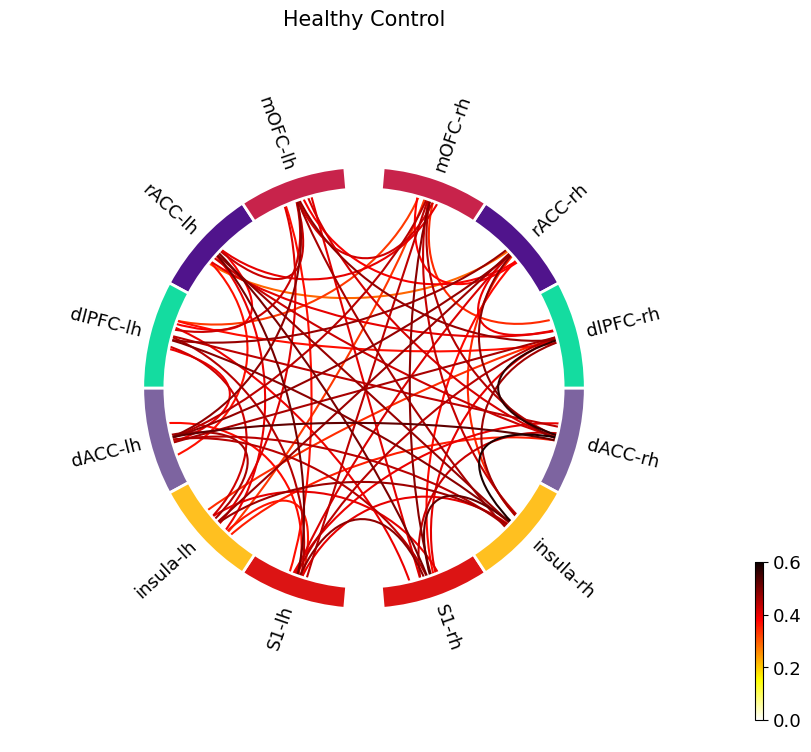

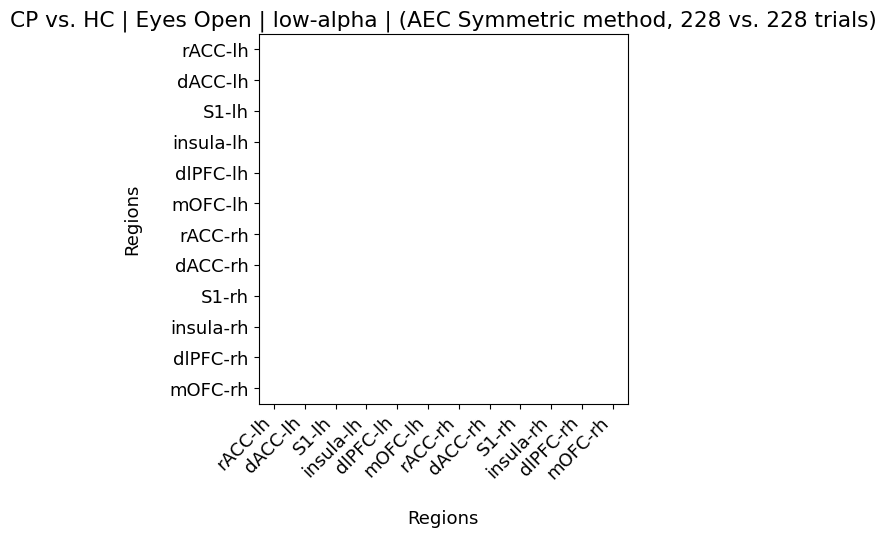

Eyes Open - Chronic Pain vs. Healthy Control - aec_symmetric - high-alpha
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|   mOFC-rh <-> S1-lh   |     3     |     0.845     |
|   S1-lh <-> dACC-lh   |     3     |     0.835     |
| insula-rh <-> dACC-lh |     3     |     0.781     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
| mOFC-lh <-> rACC-lh |     3     |     0.893     |
| mOFC-lh <-> dACC-lh |     3     |     0.814     |
|  S1-rh <-> dACC-rh  |     3     |     0.853     |
+---------------------+-----------+---------------+ 

Num epochs: 228 vs. 228
+----------------------+---------+----------------+----------------+
|   

<Figure size 640x480 with 0 Axes>

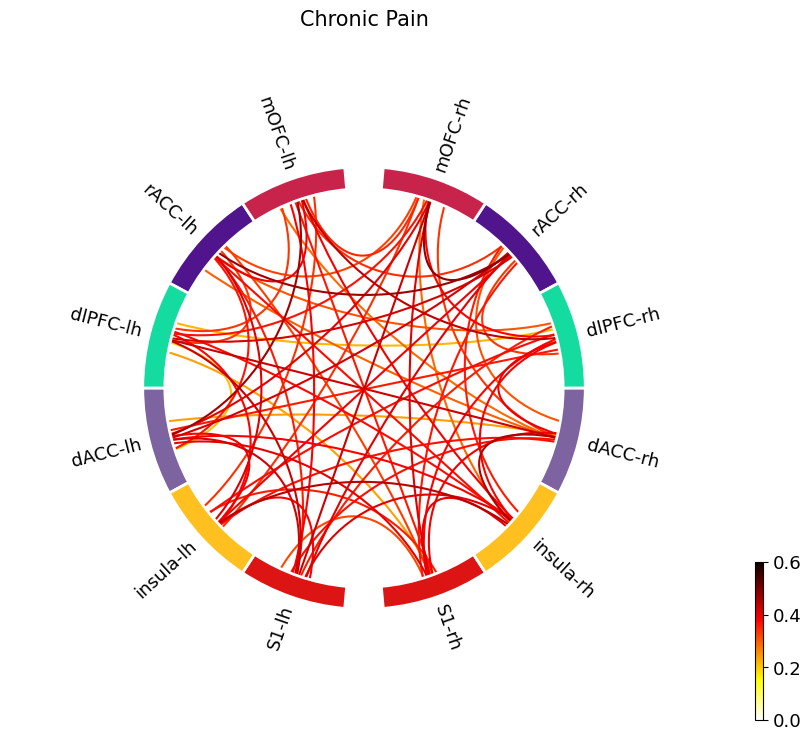

<Figure size 640x480 with 0 Axes>

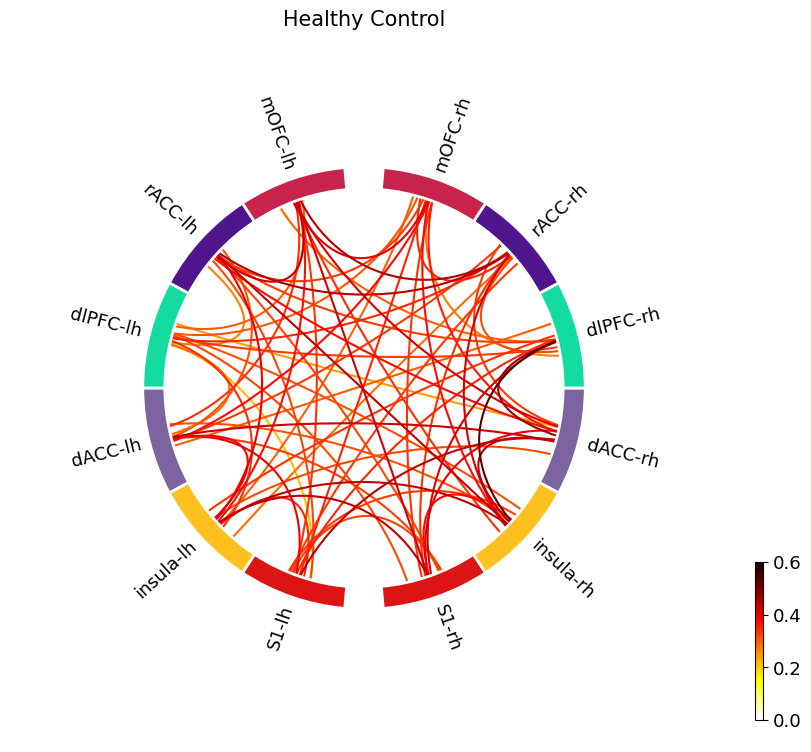

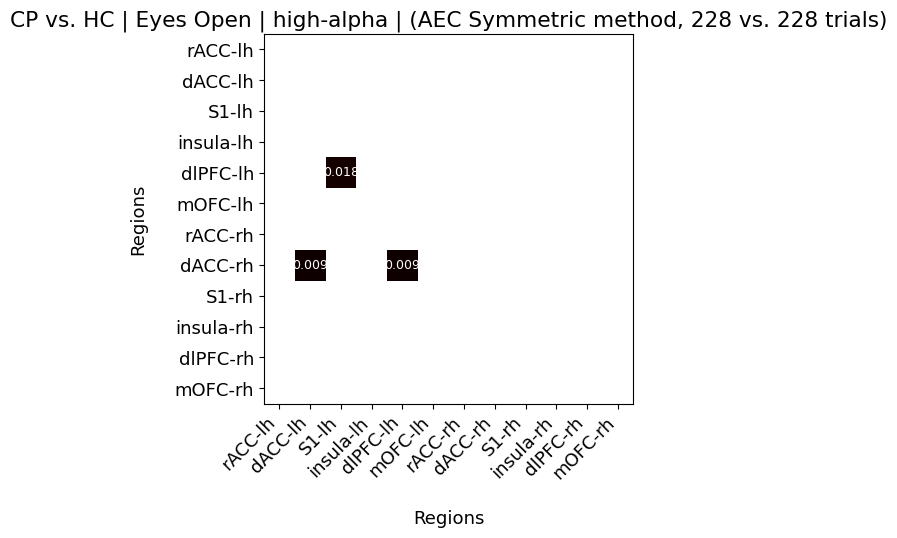

Eyes Open - Chronic Pain vs. Healthy Control - aec_symmetric - low-gamma-i
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| insula-lh <-> dACC-lh |     5     |     0.395     |
| insula-rh <-> rACC-rh |     4     |     0.447     |
|  insula-rh <-> S1-lh  |     3     |     0.513     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control group
+------------------------+-----------+---------------+
|       Connection       | Frequency | Mean Strength |
+------------------------+-----------+---------------+
| insula-rh <-> rACC-rh  |     4     |     0.484     |
| insula-rh <-> dlPFC-lh |     2     |     0.53      |
|  dACC-lh <-> rACC-lh   |     2     |     0.47      |
+------------------------+-----------+---------------+ 

Num epochs: 228 vs. 228
+-----------------------+---------+----------------

<Figure size 640x480 with 0 Axes>

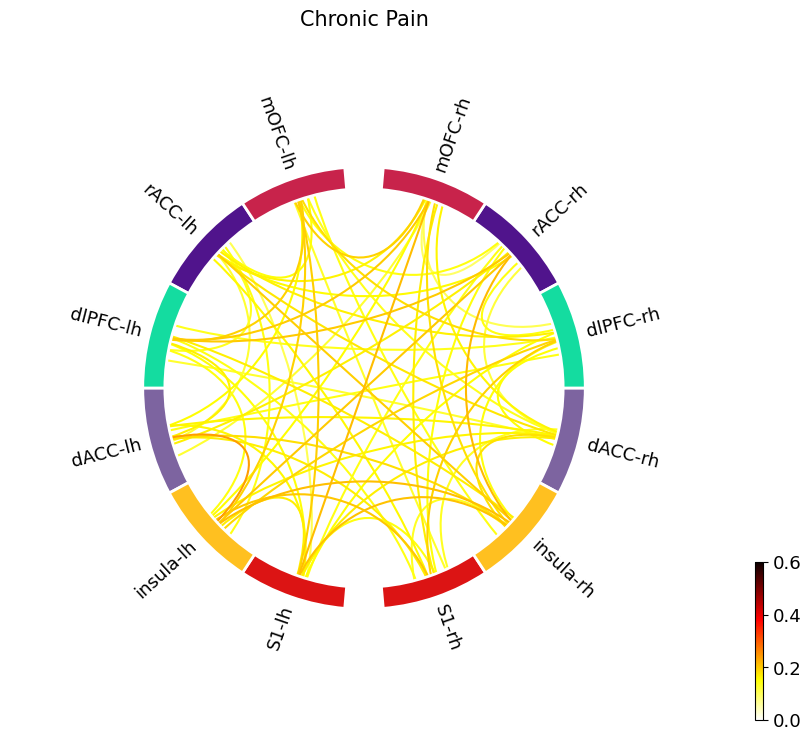

<Figure size 640x480 with 0 Axes>

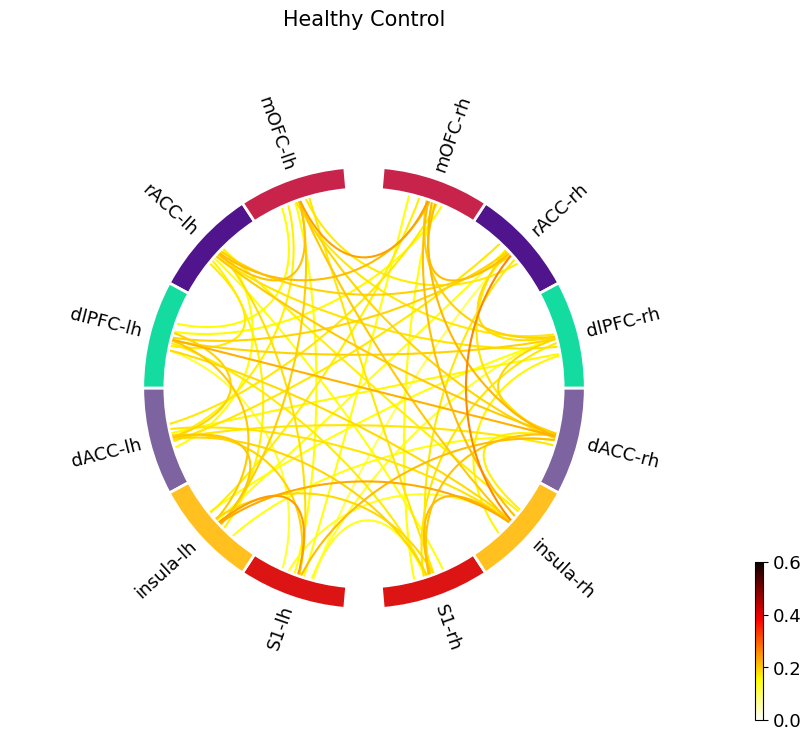

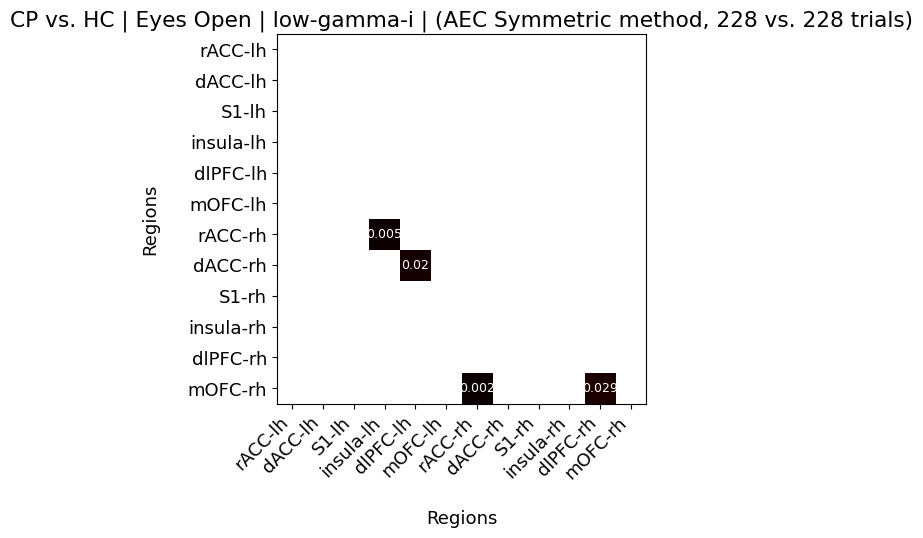

Eyes Open - Chronic Pain vs. Healthy Control - aec_symmetric - low-gamma-ii
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  dlPFC-lh <-> S1-lh   |     5     |     0.418     |
|  rACC-rh <-> rACC-lh  |     3     |     0.511     |
| insula-rh <-> rACC-rh |     3     |     0.56      |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control group
+----------------------+-----------+---------------+
|      Connection      | Frequency | Mean Strength |
+----------------------+-----------+---------------+
| dlPFC-rh <-> dACC-lh |     4     |     0.451     |
| mOFC-rh <-> rACC-lh  |     4     |     0.486     |
|  dlPFC-lh <-> S1-lh  |     3     |     0.449     |
+----------------------+-----------+---------------+ 

Num epochs: 228 vs. 228
+------------------------+---------+----------------+-----------

<Figure size 640x480 with 0 Axes>

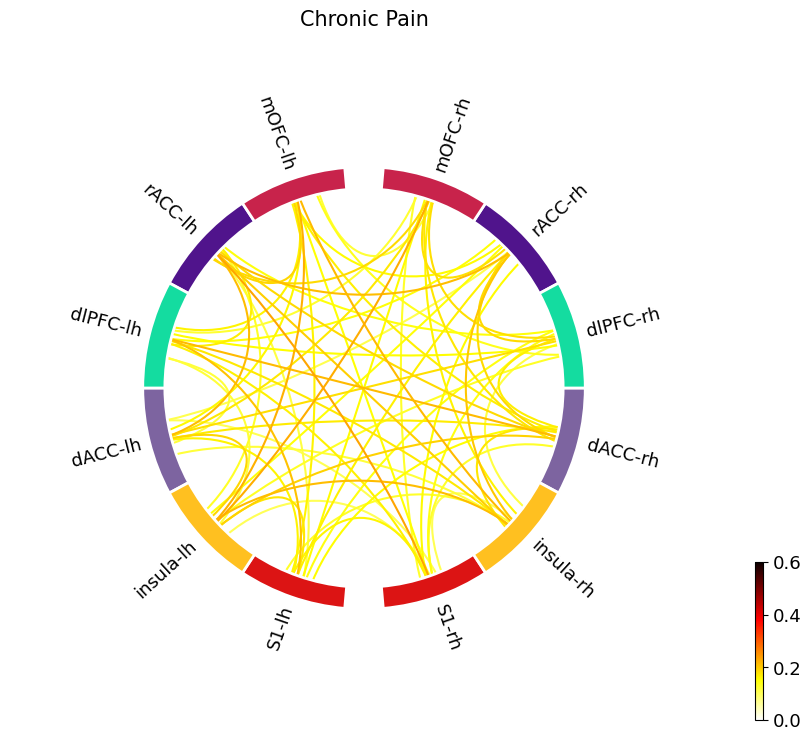

<Figure size 640x480 with 0 Axes>

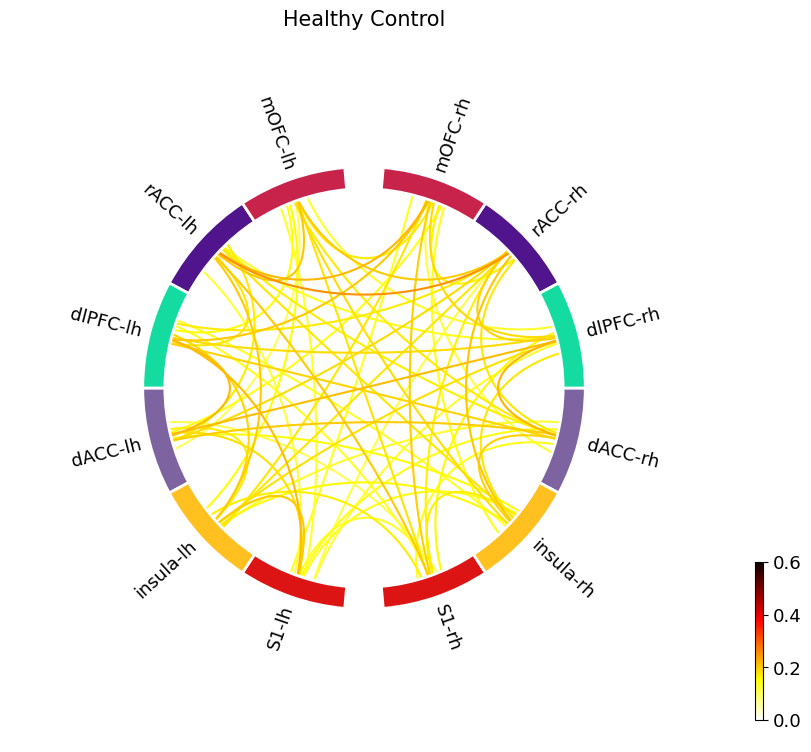

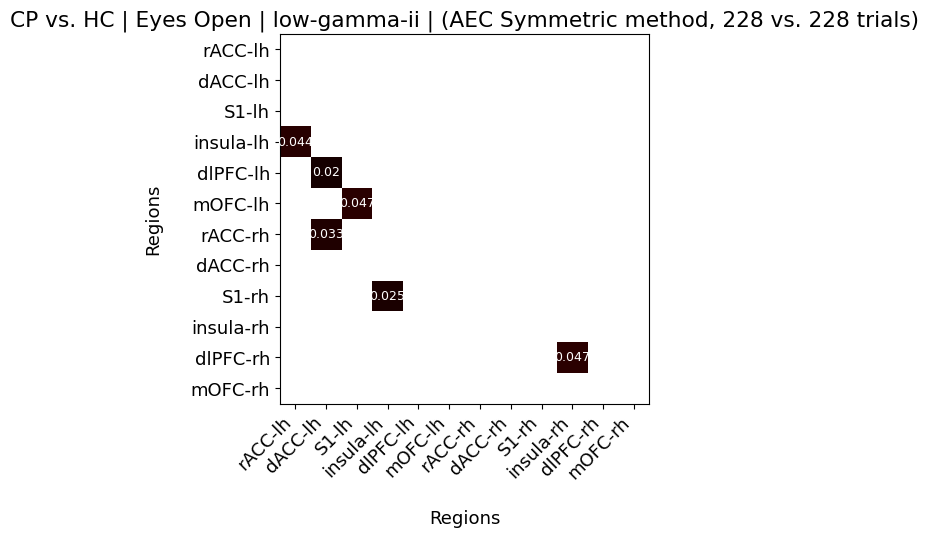

Eyes Open - Chronic Pain vs. Healthy Control - aec_symmetric - high-gamma-i
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
|  mOFC-lh <-> dACC-lh  |     4     |     0.444     |
| insula-rh <-> dACC-lh |     3     |     0.427     |
|  rACC-rh <-> rACC-lh  |     3     |     0.449     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control group
+---------------------+-----------+---------------+
|     Connection      | Frequency | Mean Strength |
+---------------------+-----------+---------------+
| mOFC-rh <-> mOFC-lh |     5     |     0.429     |
| S1-rh <-> insula-lh |     3     |     0.487     |
|  mOFC-rh <-> S1-lh  |     3     |     0.436     |
+---------------------+-----------+---------------+ 

Num epochs: 228 vs. 228
+-----------------------+---------+----------------+----------------+
|

<Figure size 640x480 with 0 Axes>

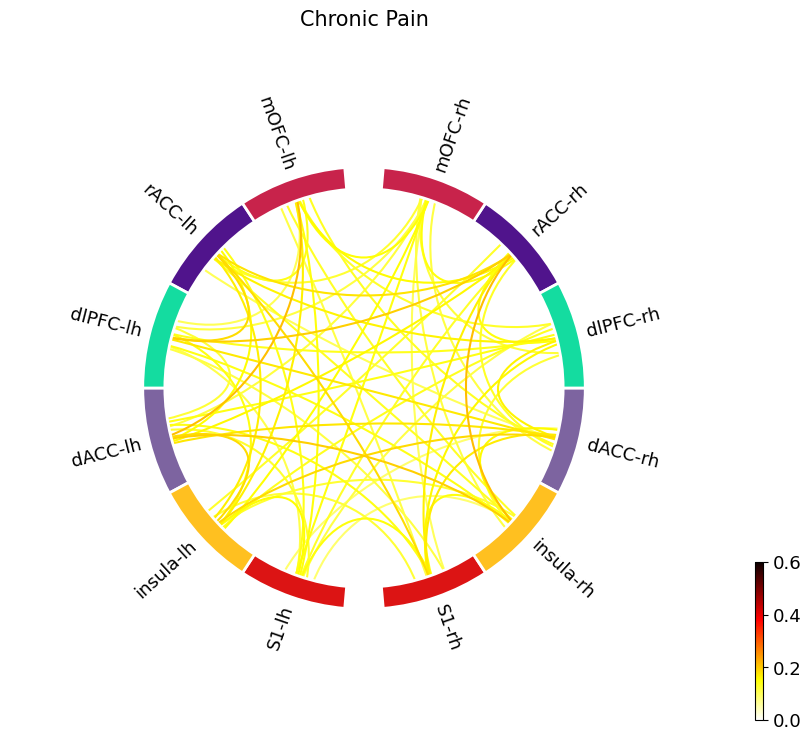

<Figure size 640x480 with 0 Axes>

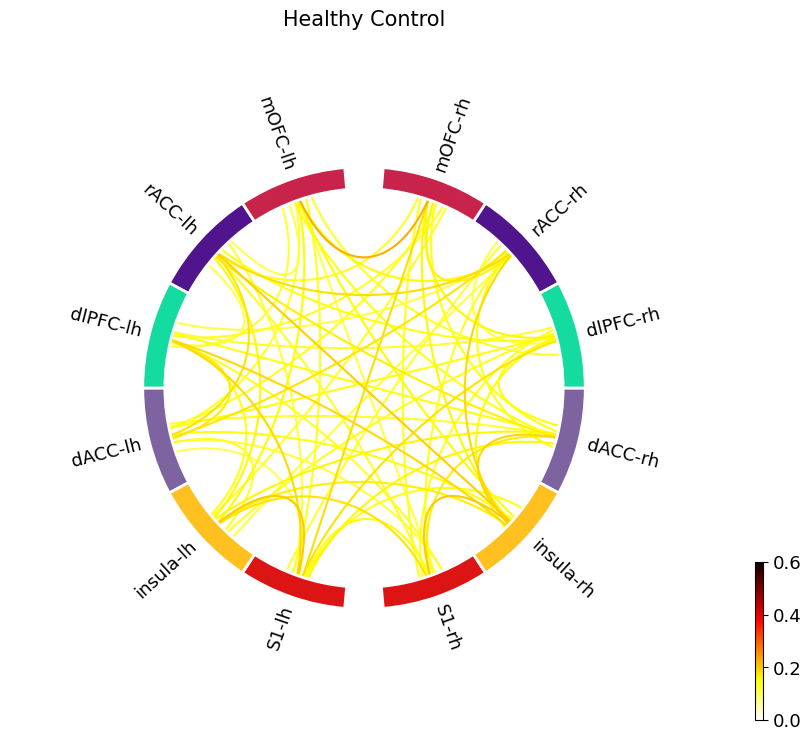

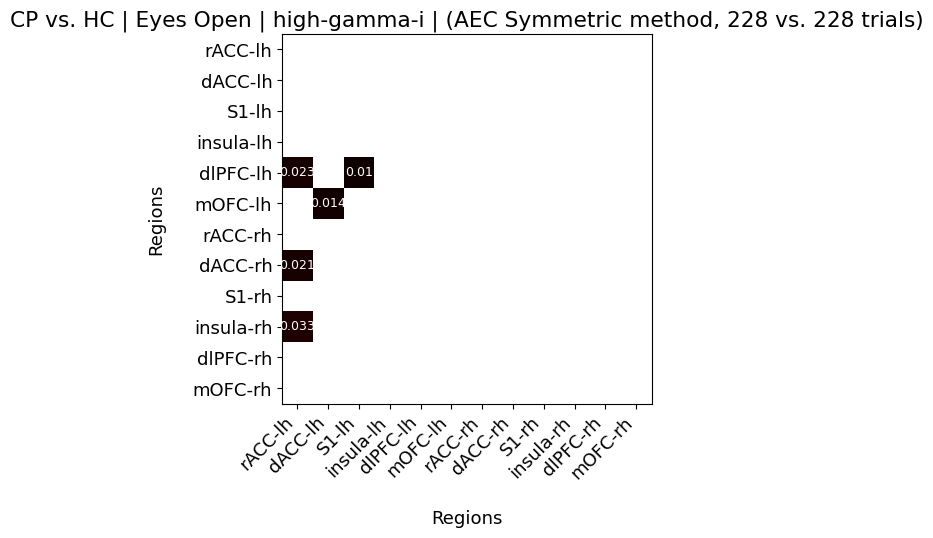

Eyes Open - Chronic Pain vs. Healthy Control - aec_symmetric - high-gamma-ii
Top 3 Connections in Chronic Pain group
+-----------------------+-----------+---------------+
|      Connection       | Frequency | Mean Strength |
+-----------------------+-----------+---------------+
| insula-rh <-> rACC-lh |     6     |     0.426     |
|  mOFC-rh <-> mOFC-lh  |     3     |     0.462     |
|  dACC-rh <-> dACC-lh  |     3     |     0.415     |
+-----------------------+-----------+---------------+ 

Top 3 Connections in Healthy Control group
+------------------------+-----------+---------------+
|       Connection       | Frequency | Mean Strength |
+------------------------+-----------+---------------+
|  rACC-rh <-> rACC-lh   |     6     |     0.432     |
| insula-rh <-> rACC-rh  |     5     |     0.529     |
| dlPFC-lh <-> insula-lh |     4     |     0.404     |
+------------------------+-----------+---------------+ 

Num epochs: 228 vs. 228
+----------------------+---------+---------------

<Figure size 640x480 with 0 Axes>

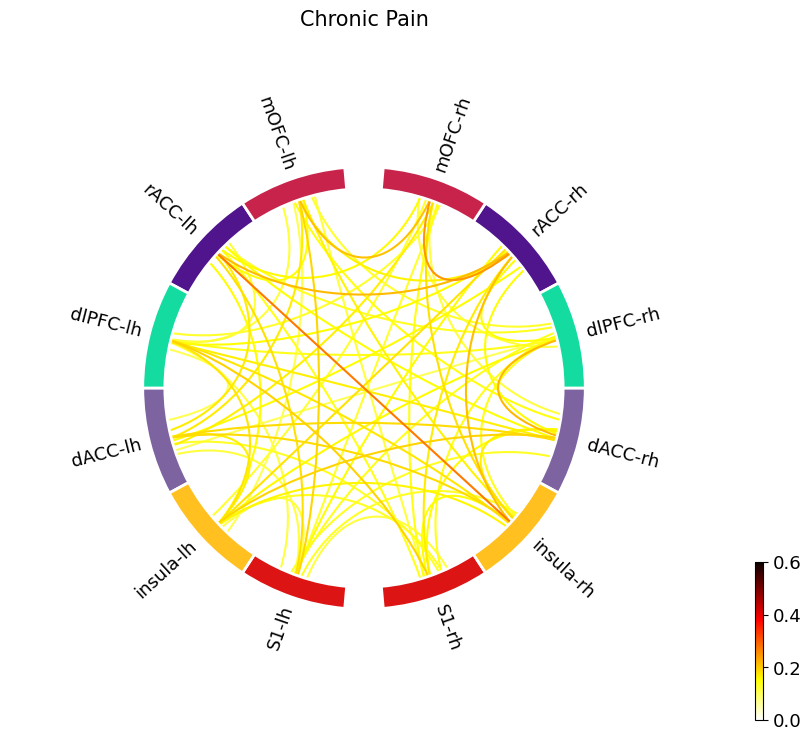

<Figure size 640x480 with 0 Axes>

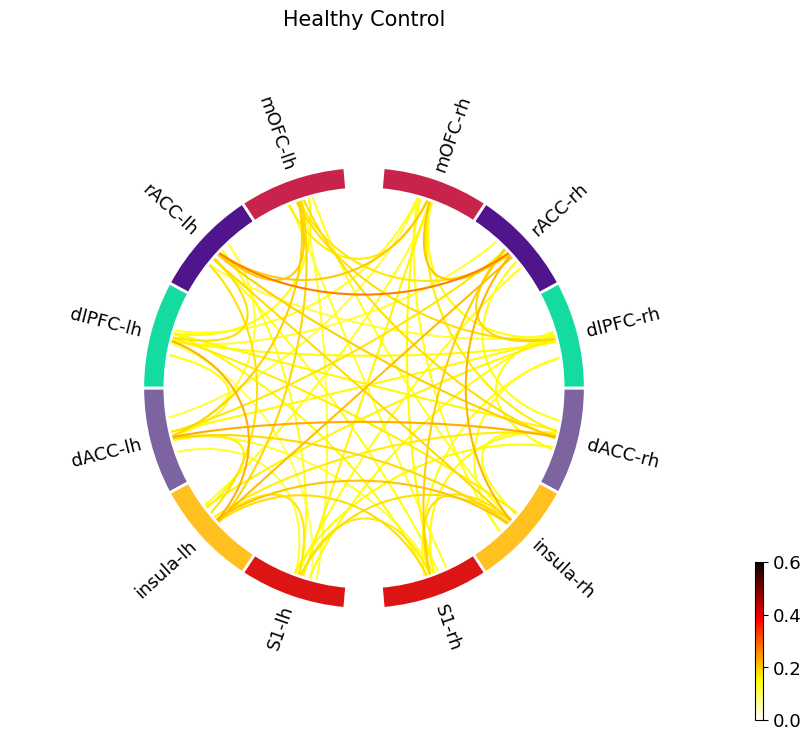

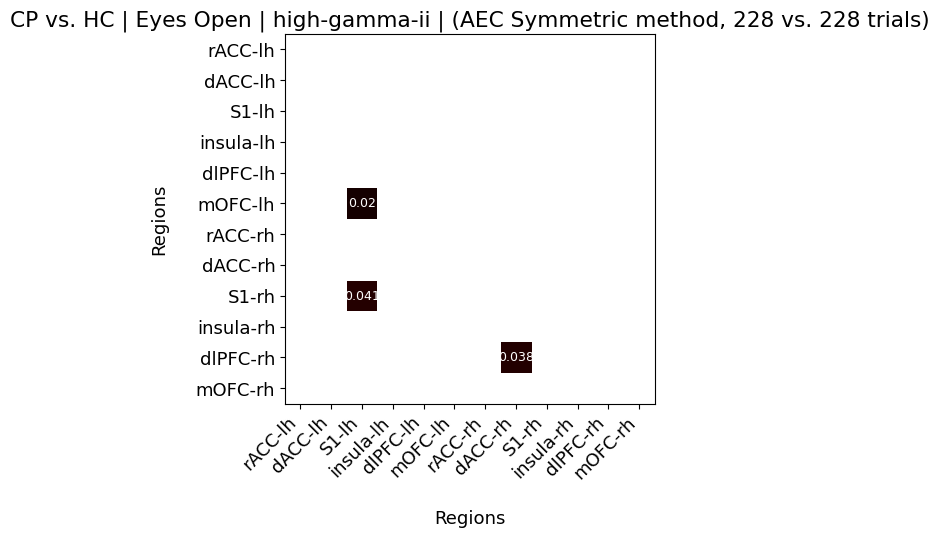

In [19]:
# CP Widespread Pain vs Healthy Control
these_group_names = ["Chronic Pain", "Healthy Control","Mann_Whitney_U_test"]
these_group_cons = [group_con_CP, group_con_HC]

for condition in conditions:
    # Make a directory for the stats
    stats_save_path = save_path / f"CP_vs_HC_{condition}"
    os.makedirs(stats_save_path, exist_ok=True)

    for method in con_methods:
        # Ignore some specific condition/method combinations
        if condition=="Hand 256 mN" and "aec" in method:
            continue
        elif condition=="Eyes Open" and method=="wpli2_debiased":
            continue

        for band in band_names:           
            # Select groups for mann-whitney
            print(f"{condition} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")

            # For each of the top 3 connections, add the connection, its frequency, and its mean strength to a list  
            for group_con,group_name in zip(these_group_cons, these_group_names):
                table_data = []  
                top_3_info = group_con[condition][method][band]["top 3"] 
                print(f"Top 3 Connections in {group_name} group")
                for i in range(3):  
                    connection = top_3_info["connections"][i]  
                    frequency = top_3_info["frequency"][i]  
                    mean_strength = top_3_info["mean strength"][i]  
                    table_data.append([f"{roi_acronyms[connection[0]]} <-> {roi_acronyms[connection[1]]}", frequency, mean_strength])  
                
                # Define table headers  
                headers = ['Connection', 'Frequency', 'Mean Strength']  
                
                # Print the table  
                print(tabulate(table_data, headers, tablefmt='pretty'),'\n')  

            group1_stack = these_group_cons[0][condition][method][band]["data"]
            group2_stack = these_group_cons[1][condition][method][band]["data"]

            nepochs_1 = these_group_cons[0][condition]['num_epochs']
            nepochs_2 = these_group_cons[1][condition]['num_epochs']
            print(f"Num epochs: {nepochs_1} vs. {nepochs_2}")

            # Compute the Mann-Whitney U test
            p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
                group1_stack, 
                group2_stack,
                roi_names,
                round_neg_vals=round_neg_vals,
                method=method)

            # Need to custom set this because the colors blow out
            if condition=="Eyes Open" and "aec" in method:
                vmin = 0.0
                vmax = 0.7
            else:
                vmin = None
                vmax = None

            # Plotting            
            # Gather the information for plotting
            plot_kwargs= dict(
                method=method,
                band=band, 
                roi_names=roi_names,
                roi_acronyms=roi_acronyms,
                condition=condition,
                vmin=vmin,
                vmax=vmax,
                group_names=these_group_names,
                nepochs=[nepochs_1, nepochs_2],
                titles=[these_group_names[0], 
                        these_group_names[1],
                        "CP vs. HC",],
                save_names=["Mann_Whitney_U_test",
                            these_group_names[0], 
                            these_group_names[1],
                            ],
                save_path=stats_save_path,
                )           

            fc.plot_connectivity_and_stats(means_1=means_1,
                                           means_2=means_2,
                                           sem_1=sem_1,
                                           sem_2=sem_2,
                                           p_values=p_values,
                                           **plot_kwargs,
                                           save_fig=True,
                                           highlight_pvals=highlight_pvals,
                                           min_fc_val=None,
                                           set_title=set_title,
                                           show_fc_vals=show_fc_vals,
                                           round_neg_vals=round_neg_vals,
            )
            
            if "aec" in method and plot_brain:
                # Convert ROI names to labels
                labels = [
                    mne.read_labels_from_annot(
                        subject, regexp=roi, subjects_dir=subjects_dir
                    )[0]
                    for roi in roi_names
                ]

                # Load the inverse1
                inv = None
                if "Eyes" not in condition:
                    inv = utils.unpickle_data(
                        zscored_epochs_data_path, f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Open":
                    inv = utils.unpickle_data(
                        EO_resting_data_path, f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Closed":
                    inv = utils.unpickle_data(
                        EC_resting_data_path, f"{sub_id}_inv.pkl"
                    )

                fc.plot_degree(
                    p_values, 
                    title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_1, 
                    title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_2, 
                    title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )

In [ ]:
# import sys  
  
# # Backup original stdout  
# orig_stdout = sys.stdout  
  
# # Open your file in write mode ('w') or append mode ('a')  
# f = open('myfile.txt', 'w')  
  
# # Set stdout to the file object  
# sys.stdout = f  
  
# # Now all print statements will be written to the file  
# print("This will be written to the file")  
  
# # Don't forget to reset the standard output to its original value  
# sys.stdout = orig_stdout  
  
# f.close()  


In [ ]:
# CP Widespread Pain vs CP without Widespread Pain
these_group_names = ["CP w/ Widespread Pain", "CP with Localized Pain","Mann_Whitney_U_test"]
these_group_cons = [group_con_CP_WSP, group_con_CP_LP]

for condition in conditions:
    # Make a directory for the stats
    stats_save_path = save_path / f"CP_WSP_vs_CP_LP_{condition}"
    os.makedirs(stats_save_path, exist_ok=True)

    for method in con_methods:
        for band in band_names:
            # Ignore some specific condition/method combinations
            if "Hand" in condition and "AEC" in method:
                continue
            elif "Eyes" in condition and "wpli" in method:
                continue
            
            # Select groups for mann-whitney
            print(f"{condition} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")

            # For each of the top 3 connections, add the connection, its frequency, and its mean strength to a list  
            for group_con,group_name in zip(these_group_cons, these_group_names):
                table_data = []  
                top_3_info = group_con[condition][method][band]["top 3"] 
                print(f"Top 3 Connections in {group_name} group")
                for i in range(3):  
                    connection = top_3_info["connections"][i]  
                    frequency = top_3_info["frequency"][i]  
                    mean_strength = top_3_info["mean strength"][i]  
                    table_data.append([f"{roi_acronyms[connection[0]]} <-> {roi_acronyms[connection[1]]}", frequency, mean_strength])  
                
                # Define table headers  
                headers = ['Connection', 'Frequency', 'Mean Strength']  
                
                # Print the table  
                print(tabulate(table_data, headers, tablefmt='pretty'),'\n')  

            group1_stack = these_group_cons[0][condition][method][band]["data"]
            group2_stack = these_group_cons[1][condition][method][band]["data"]

            nepochs_1 = these_group_cons[0][condition]['num_epochs']
            nepochs_2 = these_group_cons[1][condition]['num_epochs']
            print(f"Num epochs: {nepochs_1} vs. {nepochs_2}")
            
            # Compute the Mann-Whitney U test
            p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
                group1_stack,
                group2_stack,
                roi_names,
                round_neg_vals=round_neg_vals,
                method=method)

            # Need to custom set this
            if "aec" in method and "Eyes" in condition:
                vmin = 0.0
                vmax = 0.6
            else:
                vmin = None
                vmax = None

            # Plotting            
            # Gather the information for plotting
            plot_kwargs= dict(
                method=method,
                band=band, 
                roi_names=roi_names,
                roi_acronyms=roi_acronyms,
                condition=condition,
                vmin=vmin,
                vmax=vmax,
                group_names=these_group_names,
                nepochs=[nepochs_1, nepochs_2],
                titles=[these_group_names[0], 
                        these_group_names[1],
                        "CP w/ WSP vs. CP w/ LP",],
                save_names=["Mann_Whitney_U_test",
                            these_group_names[0], 
                            these_group_names[1],
                            ],
                save_path=stats_save_path,
                )
                                
            fc.plot_connectivity_and_stats(means_1=means_1,
                                           means_2=means_2,
                                           sem_1=sem_1,
                                           sem_2=sem_2,
                                           p_values=p_values,
                                           **plot_kwargs,
                                           save_fig=True,
                                           highlight_pvals=highlight_pvals,
                                           min_fc_val=None,
                                           set_title=set_title,
                                           show_fc_vals=show_fc_vals,
                                           round_neg_vals=round_neg_vals,
            )
        
            if "aec" in method and plot_brain:
                # Convert ROI names to labels
                labels = [
                    mne.read_labels_from_annot(
                        subject, regexp=roi, subjects_dir=subjects_dir
                    )[0]
                    for roi in roi_names
                ]

                # Load the inverse
                inv = None
                if "Eyes" not in condition:
                    inv = utils.unpickle_data(
                        zscored_epochs_data_path, f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Open":
                    inv = utils.unpickle_data(
                        EO_resting_data_path, f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Closed":
                    inv = utils.unpickle_data(
                        EC_resting_data_path, f"{sub_id}_inv.pkl"
                    )

                fc.plot_degree(
                    p_values, 
                    title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_1, 
                    title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_2, 
                    title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )
        

## Plot individual data in each group

### Plot settings

In [ ]:
exit()

In [ ]:
# CP Widespread Pain
this_group_name = "Chronic Pain"
this_group_cons = sub_con_CP
n=len(roi_names)

low_trial_subs = ['036,037','044','055','056','058']
# done_subs=[sub for sub in sub_ids_CP if sub not in done_subs]

subs_gen = (sub_id for sub_id in this_group_cons if sub_id in low_trial_subs)

for sub_id in subs_gen:
    for condition in conditions:
        # Make a directory for the stats
        stats_save_path = save_path / f"CP_individual_{condition}"
        os.makedirs(stats_save_path, exist_ok=True)
        for method in con_methods:
            for band in band_names:
                # Select groups for mann-whitney
                print(f"{condition} - {sub_id} - {this_group_name} - {method} - {band}")
                group1_stack = this_group_cons[sub_id][condition][method][band]["data"]
                nepochs_1 = this_group_cons[sub_id][condition]['num_epochs']
                print(f"Num epochs: {nepochs_1}")

                # Plotting
                # Gather the information for plotting
                plot_kwargs= dict(
                    method=method,
                    band=band, 
                    roi_names=roi_names,
                    roi_acronyms=roi_acronyms,
                    condition=condition,
                    group_names=this_group_name,
                    nepochs=[nepochs_1],
                    titles=[f"Subject {sub_id} - {condition} - {method} - {band} ({nepochs_1} trials)"],
                    save_names=[this_group_name],
                    save_path=stats_save_path,
                    )
            
                fc.plot_connectivity_and_stats(
                    means_1=group1_stack,
                    **plot_kwargs,
                    save_fig=True,
                    highlight_pvals=highlight_pvals,
                    show_only_significant=show_only_significant,
                    min_fc_val=None,
                    set_title=set_title,
                    show_fc_vals=show_fc_vals,
                    round_neg_vals=round_neg_vals,
                )

                if "aec" in method and plot_brain:
                    # Convert ROI names to labels
                    labels = [
                        mne.read_labels_from_annot(
                            subject, regexp=roi, subjects_dir=subjects_dir
                        )[0]
                        for roi in roi_names
                    ]

                    # Load the inverse
                    inv = None
                    if "Eyes" not in condition:
                        inv = utils.unpickle_data(zscored_epochs_data_path,
                                                  f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Open":
                        inv = utils.unpickle_data(EO_resting_data_path,
                                                  f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Closed":
                        inv = utils.unpickle_data(EC_resting_data_path,
                                                  f"{sub_id}_inv.pkl"
                        )

                    fc.plot_degree(
                        p_values, 
                        title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_1, 
                        title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_2, 
                        title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )

In [ ]:
# CP Widespread Pain
this_group_name = "Healthy Control"
this_group_cons = sub_con_HC
n=len(roi_names)

done_subs=[]

subs_gen = (sub_id for sub_id in this_group_cons if sub_id not in done_subs)

for sub_id in subs_gen:
    for condition in conditions:
        # Make a directory for the stats
        stats_save_path = save_path / f"CP_individual_{condition}"
        os.makedirs(stats_save_path, exist_ok=True)
        for method in con_methods:
            for band in band_names:
                # Select groups for mann-whitney
                print(f"{condition} - {sub_id} - {this_group_name} - {method} - {band}")
                group1_stack = this_group_cons[sub_id][condition][method][band]["data"]
                nepochs_1 = this_group_cons[sub_id][condition]['num_epochs']
                print(f"Num epochs: {nepochs_1}")

                # Plotting
                # Gather the information for plotting
                plot_kwargs= dict(
                    method=method,
                    band=band, 
                    roi_names=roi_names,
                    roi_acronyms=roi_acronyms,
                    condition=condition,
                    group_names=this_group_name,
                    nepochs=[nepochs_1],
                    titles=[f"Subject {sub_id} - {condition} - {method} - {band} ({nepochs_1} trials)"],
                    save_names=[this_group_name],
                    save_path=stats_save_path,
                    )
            
                fc.plot_connectivity_and_stats(
                    means_1=group1_stack,
                    **plot_kwargs,
                    save_fig=True,
                    highlight_pvals=highlight_pvals,
                    show_only_significant=show_only_significant,
                    min_fc_val=None,
                    set_title=set_title,
                    show_fc_vals=show_fc_vals,
                    round_neg_vals=round_neg_vals,
                )

                if "aec" in method and plot_brain:
                    # Convert ROI names to labels
                    labels = [
                        mne.read_labels_from_annot(
                            subject, regexp=roi, subjects_dir=subjects_dir
                        )[0]
                        for roi in roi_names
                    ]

                    # Load the inverse
                    inv = None
                    if "Eyes" not in condition:
                        inv = utils.unpickle_data(zscored_epochs_data_path,
                                                  f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Open":
                        inv = utils.unpickle_data(EO_resting_data_path,
                                                  f"{sub_id}_inv.pkl"
                        )
                    elif condition == "Eyes Closed":
                        inv = utils.unpickle_data(EC_resting_data_path,
                                                  f"{sub_id}_inv.pkl"
                        )

                    fc.plot_degree(
                        p_values, 
                        title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_1, 
                        title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                        labels=labels, 
                        inv=inv,
                    )
                    fc.plot_degree(
                        means_2, 
                        title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                        labels=labels, 
                        inv=inv,
                    )